In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from collections import Counter
from openpyxl import load_workbook
from difflib import get_close_matches
import unicodedata


In [2]:

def fill_model_metrics_into_excel(
    df: pd.DataFrame,
    model_name: str,
    selected_metrics = None,
    excel_path: str = None,
    output_path: str = None,
    sheet_name: str = None,
):
    # Normalize to avoid invisible characters and spaces
    def normalize(text: str) -> str:
        if text is None:
            return ""
        return unicodedata.normalize('NFKC', str(text)).strip().replace('\xa0', ' ')

    # Default to MSE and WAPE if not specified
    if selected_metrics is None:
        selected_metrics = ["MSE", "WAPE"]
    else:
        selected_metrics = [m.upper() for m in selected_metrics]

    # Extract pred_len
    pred_len_values = df["pred_len"].unique()
    if len(pred_len_values) != 1:
        raise ValueError(f"Expected a single pred_len, got: {pred_len_values}")
    pred_len = int(pred_len_values[0])

    # Load workbook and worksheet
    wb = load_workbook(excel_path)
    if sheet_name:
        if sheet_name not in wb.sheetnames:
            raise ValueError(f"Sheet '{sheet_name}' not found in workbook. Available: {wb.sheetnames}")
        ws = wb[sheet_name]
    else:
        ws = wb.active

    # Map model and metric columns
    col_map = {}
    target = normalize(model_name)

    print(f"🔎 Looking for model: {repr(target)}")
    for col in range(3, ws.max_column + 1):
        model_cell = ws.cell(row=1, column=col).value
        model_clean = normalize(model_cell)
        if model_clean != target:
            continue

        metric_name = ws.cell(row=2, column=col).value
        if not metric_name:
            continue

        metric_name = normalize(metric_name).upper()
        print(f"  Col {col}: model={repr(model_clean)} | metric={metric_name}")

        if metric_name in selected_metrics:
            col_map[metric_name] = col

    if not col_map:
        raise ValueError(
            f"No matching columns found for model '{model_name}' and metrics {selected_metrics}"
        )

    # Function to find or append target row
    def find_or_insert_row(group: str, pred_len: int):
        for row in range(3, ws.max_row + 1):
            g = ws.cell(row=row, column=1).value
            p = ws.cell(row=row, column=2).value
            try:
                if g == group and int(p) == int(pred_len):
                    return row
            except:
                continue
        # Not found: insert
        new_row = ws.max_row + 1
        ws.cell(row=new_row, column=1, value=group)
        ws.cell(row=new_row, column=2, value=pred_len)
        return new_row

    # Fill values
    for _, row_data in df.iterrows():
        group = row_data["group"]
        row_idx = find_or_insert_row(group, pred_len)
        for metric in selected_metrics:
            col_idx = col_map.get(metric)
            if col_idx is None:
                continue
            val = (
                row_data.get(metric.lower()) or
                row_data.get(metric.upper()) or
                row_data.get(metric)
            )
            if pd.notna(val):
                ws.cell(row=row_idx, column=col_idx, value=float(val))

    save_path = output_path or excel_path
    wb.save(save_path)
    print(f"✅ Filled '{model_name}' (pred_len={pred_len}) into: {save_path}, sheet: {ws.title}")


In [3]:

def show_results(root_dir):
    summary_results = []
    total_json_count = 0
    all_model_paths = []

    # === Traverse and summarize ===
    for group_dir in sorted(root_dir.iterdir()):
        if not group_dir.is_dir():
            continue

        metrics_list = []

        for subdir in group_dir.iterdir():
            if not subdir.is_dir():
                continue

            json_file = subdir / "results.json"
            if json_file.exists():
                total_json_count += 1
                with open(json_file, "r") as f:
                    data = json.load(f)
                    data["group"] = group_dir.name
                    metrics_list.append(data)
                    all_model_paths.append(data.get("model_path", "unknown"))

        if metrics_list:
            df = pd.DataFrame(metrics_list)
            df_mean = df.drop(columns=["dataset", "freq", "model_path"]).mean(numeric_only=True)
            df_mean["group"] = group_dir.name
            summary_results.append(df_mean)

    # === Combine summaries ===
    summary_df = pd.DataFrame(summary_results)
    summary_df.sort_values("group", inplace=True)

    # === Display summary table ===
    print("\n📊 Summary of Mean Metrics per Dataset Group:")
    display(summary_df)

    # === Compute overall global mean across all groups ===
    global_means = summary_df.drop(columns=["group"]).mean(numeric_only=True)
    print("\n📌 Global Mean Across All Groups:")
    print(global_means.round(4))

    # === Determine model name to display in title ===
    model_name = Counter(all_model_paths).most_common(1)[0][0] if all_model_paths else "Unknown Model"

    # === Visualization ===
    plt.figure(figsize=(12, 6))
    for metric in ["mse", "mae", "smape", "wape", "nrmse"]:
        if metric in summary_df.columns:
            plt.plot(summary_df["group"], summary_df[metric], marker='o', label=metric)

    plt.xticks(rotation=45)
    plt.xlabel("Dataset Group")
    plt.ylabel("Metric Value")
    plt.title(f"Average Forecasting Metrics by Dataset Group\nModel: {model_name} pred len: {summary_df['pred_len'][0]} context len: {summary_df['context_len'][0]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Total json count ===
    print(f"\n🔢 Total number of results.json files found: {total_json_count}")

    return summary_df

In [4]:
excel_file_path = r"C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx"
wb = load_workbook(excel_file_path)
ws = wb.active
# Parse all model name columns
model_col_map = {}
for col in range(3, ws.max_column + 1, 1):
    model = ws.cell(row=1, column=col).value
    if model is None:
        continue
    model = model.strip()
    model_col_map[model] = {
    }

print("Available models in Excel headers:", list(model_col_map.keys()))

def print_excel_sheet_contents(excel_path, sheet_name=None):
    wb = load_workbook(excel_path, data_only=True)
    ws = wb[sheet_name] if sheet_name else wb.active

    print("=== Excel Sheet Content ===")
    for row in ws.iter_rows(values_only=True):
        print(row)

#print_excel_sheet_contents(excel_file_path)


Available models in Excel headers: ['TimesFM 200M', 'TimesFM 500M', 'Chronos small', 'Chronos Medium', 'Chronos Large', 'TimesMOE Large', 'FTFM v4 lowq (mean)', 'FTFM v4 (medium5)', 'FTFM v4 (mean)', 'FTFM v3t  (median5)', 'FTFM v3t DDP  (median5)']


## Work Section


📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.053624  0.215265  0.115258  0.145289  0.279531   3173.333333   
1   0.009456  0.165440  0.062387  0.073022  0.112159  20360.000000   
2   0.011496  0.171012  0.068184  0.078989  0.124161   8333.333333   
3   0.033551  0.242081  0.129841  0.146913  0.206833   6420.000000   
4   0.015055  0.184692  0.077483  0.091728  0.139786  20226.666667   
5   0.036026  0.245128  0.120608  0.140803  0.209165  11680.000000   
6   0.222757  0.622518  0.312019  0.408058  0.629523   1520.000000   
7   0.040137  0.345620  0.124867  0.163803  0.246874   6760.000000   
8   0.012065  0.157751  0.070678  0.081308  0.126360  15640.000000   
9   0.226620  0.311149  0.196459  0.240336  0.375096   8633.333333   
10  0.104496  0.359801  0.236907  0.285400  0.389425   1520.000000   
11  0.063516  0.358005  0.153236  0.200863  0.293982   6329.270386   
12  0.056603  0.348820  0.149625  0.188969  0.285588   5197.000000   
13  0.136943  0.521139  0.227826  0.310649  0.486598   2496.752137   
14  0.119781  0.474752  0.222897  0.290041  0.420871   1828.705882   

         abs_sum  total_time  pred_len  context_len                 group  
0    2622.283529   12.707186      10.0        128.0           crypto10_1d  
1   17353.266602   77.963964      10.0        128.0           crypto10_1h  
2    7184.560872   30.805048      10.0        128.0           crypto10_1m  
3    5675.617920   23.870467      10.0        128.0     forex_datasets_1d  
4   17314.160807   74.239986      10.0        128.0     forex_datasets_1h  
5   10106.773763   42.914597      10.0        128.0     forex_datasets_1m  
6    1196.905497    5.741751      10.0        128.0    forex_datasets_1wk  
7    5121.516357   24.944983      10.0        128.0   futures_datasets_1d  
8   13595.334961   57.833095      10.0        128.0   futures_datasets_1h  
9    7449.247111   31.661694      10.0        128.0   futures_datasets_1m  
10   1261.736206    5.843038      10.0        128.0  futures_datasets_1wk  
11   5063.375805   23.149468      10.0        128.0     stock_datasets_1d  
12   4207.023304   19.124253      10.0        128.0     stock_datasets_1h  
13   1876.309469    9.184666      10.0        128.0     stock_datasets_1m  
14   1425.855316    6.760370      10.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.0761
smape              0.3149
mae                0.1512
wape               0.1897
nrmse              0.2884
num_elements    8007.8930
abs_sum         6763.5978
total_time        29.7830
pred_len          10.0000
context_len      128.0000
dtype: float64


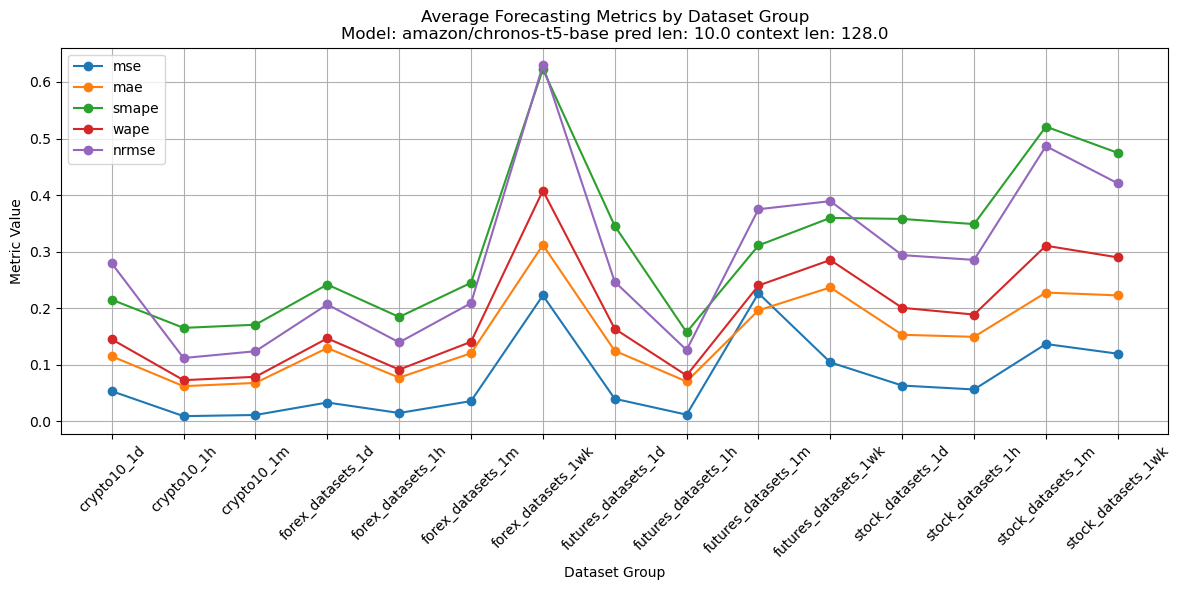


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=MSE
✅ Filled 'Chronos Medium' (pred_len=10) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: mse

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.087312  0.280281  0.152936  0.191467  0.361989   3173.333333   
1   0.018418  0.218928  0.089994  0.105382  0.156320  20320.000000   
2   0.024810  0.243412  0.100144  0.116643  0.183470   8293.333333   
3   0.060883  0.308675  0.172666  0.195584  0.277265   6400.000000   
4   0.029456  0.245448  0.110582  0.131102  0.194371  20213.333333   
5   0.066490  0.318125  0.166886  0.194656  0.289240  11680.000000   
6   0.374573  0.759461  0.430768  0.561295  0.811805   1520.000000   
7   0.068766  0.428529  0.166522  0.218527  0.325556   6760.000000   
8   0.020311  0.201536  0.098653  0.113432  0.163867  15600.000000   
9   0.244001  0.371405  0.231191  0.281210  0.426030   8626.666667   
10  0.156739  0.437424  0.290482  0.349941  0.476940   1520.000000   
11  0.110961  0.450892  0.208619  0.273143  0.391304   6315.879828   
12  0.104379  0.442198  0.206947  0.262442  0.390144   5163.666667   
13  0.269906  0.659430  0.321957  0.442508  0.688412   2474.188034   
14  0.202016  0.589165  0.296535  0.386554  0.548208   1821.176471   

         abs_sum  total_time  pred_len  context_len                 group  
0    2622.283936   10.954636      20.0        128.0           crypto10_1d  
1   17313.417969   69.238795      20.0        128.0           crypto10_1h  
2    7123.527507   28.246483      20.0        128.0           crypto10_1m  
3    5655.123047   22.082682      20.0        128.0     forex_datasets_1d  
4   17302.552083   68.413620      20.0        128.0     forex_datasets_1h  
5   10106.771484   39.869170      20.0        128.0     forex_datasets_1m  
6    1196.905538    5.300640      20.0        128.0    forex_datasets_1wk  
7    5121.516602   23.066282      20.0        128.0   futures_datasets_1d  
8   13567.410156   53.387169      20.0        128.0   futures_datasets_1h  
9    7438.841838   29.367866      20.0        128.0   futures_datasets_1m  
10   1261.736206    5.502228      20.0        128.0  futures_datasets_1wk  
11   5045.140767   21.194611      20.0        128.0     stock_datasets_1d  
12   4163.177339   17.270096      20.0        128.0     stock_datasets_1h  
13   1848.851493    8.300601      20.0        128.0     stock_datasets_1m  
14   1413.295853    6.122761      20.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.1226
smape              0.3970
mae                0.2030
wape               0.2549
nrmse              0.3790
num_elements    7992.1052
abs_sum         6745.3701
total_time        27.2212
pred_len          20.0000
context_len      128.0000
dtype: float64


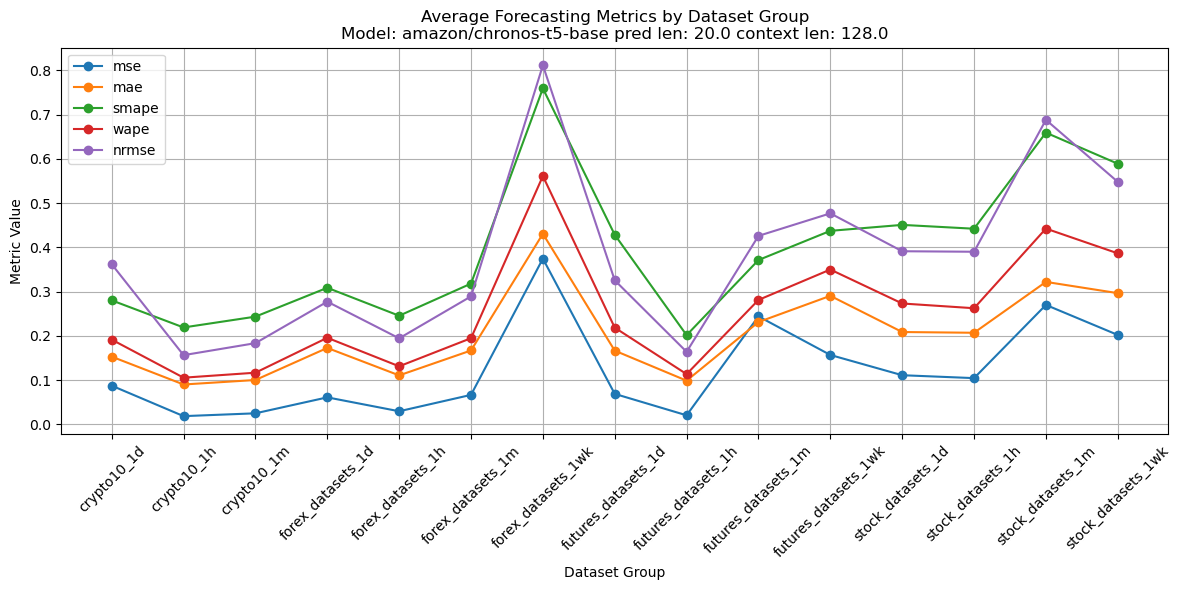


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=MSE
✅ Filled 'Chronos Medium' (pred_len=20) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: mse

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.138484  0.327624  0.193239  0.243750  0.460921   3120.000000   
1   0.024730  0.250653  0.105444  0.123557  0.180662  20280.000000   
2   0.043907  0.288132  0.133096  0.155084  0.242825   8280.000000   
3   0.089522  0.382582  0.222182  0.251604  0.335276   6360.000000   
4   0.041786  0.290885  0.135661  0.161289  0.234440  20160.000000   
5   0.092907  0.361713  0.200457  0.233680  0.345873  11640.000000   
6   0.388735  0.786881  0.435010  0.578279  0.835189   1440.000000   
7   0.103577  0.504710  0.205870  0.270992  0.396926   6720.000000   
8   0.031607  0.257145  0.125619  0.144438  0.204419  15600.000000   
9   0.260469  0.410703  0.254724  0.309146  0.462246   8580.000000   
10  0.211026  0.549855  0.335453  0.416046  0.569741   1440.000000   
11  0.164940  0.528453  0.256733  0.338191  0.480625   6282.746781   
12  0.149158  0.509141  0.250859  0.317585  0.464735   5163.500000   
13  0.308858  0.737657  0.364811  0.505015  0.740988   2445.641026   
14  0.278204  0.674081  0.354181  0.471722  0.656391   1766.823529   

         abs_sum  total_time  pred_len  context_len                 group  
0    2559.130046   10.494509      30.0        128.0           crypto10_1d  
1   17267.364258   67.066345      30.0        128.0           crypto10_1h  
2    7102.145345   27.458822      30.0        128.0           crypto10_1m  
3    5625.184814   21.325132      30.0        128.0     forex_datasets_1d  
4   17212.069661   66.109466      30.0        128.0     forex_datasets_1h  
5   10062.485677   38.503162      30.0        128.0     forex_datasets_1m  
6    1117.053060    4.923247      30.0        128.0    forex_datasets_1wk  
7    5068.270996   22.299176      30.0        128.0   futures_datasets_1d  
8   13567.412109   52.102547      30.0        128.0   futures_datasets_1h  
9    7389.731608   28.339815      30.0        128.0   futures_datasets_1m  
10   1161.055664    5.075302      30.0        128.0  futures_datasets_1wk  
11   5008.751638   20.498755      30.0        128.0     stock_datasets_1d  
12   4168.045179   16.864363      30.0        128.0     stock_datasets_1h  
13   1808.626365    7.998626      30.0        128.0     stock_datasets_1m  
14   1343.625452    5.776524      30.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.1552
smape              0.4573
mae                0.2382
wape               0.3014
nrmse              0.4408
num_elements    7951.9141
abs_sum         6697.3968
total_time        26.3224
pred_len          30.0000
context_len      128.0000
dtype: float64


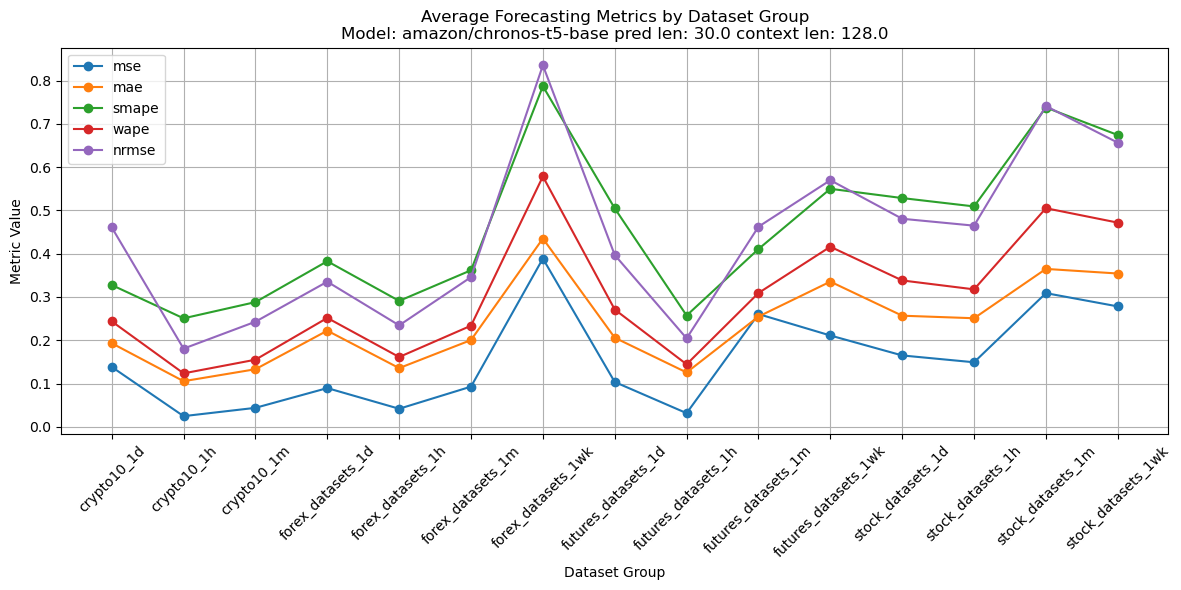


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=MSE
✅ Filled 'Chronos Medium' (pred_len=30) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: mse

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.250216  0.453631  0.278767  0.351668  0.627806   3120.000000   
1   0.050495  0.332269  0.148321  0.174149  0.256700  20160.000000   
2   0.091866  0.396997  0.199059  0.232405  0.354221   8240.000000   
3   0.155244  0.483940  0.291053  0.331533  0.447304   6240.000000   
4   0.087859  0.393457  0.195392  0.232441  0.333968  20080.000000   
5   0.193314  0.484268  0.282717  0.330474  0.501328  11520.000000   
6   0.721485  0.979455  0.603891  0.788140  1.120183   1440.000000   
7   0.229425  0.610338  0.292865  0.388836  0.593901   6600.000000   
8   0.050622  0.288742  0.159396  0.183275  0.258700  15600.000000   
9   0.301169  0.484777  0.305360  0.367516  0.542156   8520.000000   
10  0.348858  0.643870  0.426013  0.528362  0.732544   1440.000000   
11  0.295300  0.672839  0.357116  0.472313  0.653507   6237.939914   
12  0.261253  0.647109  0.343926  0.436536  0.619640   5124.000000   
13  0.544892  0.938108  0.509478  0.709443  0.995843   2416.410256   
14  0.443772  0.850564  0.469621  0.631354  0.854157   1743.529412   

         abs_sum  total_time  pred_len  context_len                 group  
0    2559.130086   10.512485      60.0        128.0           crypto10_1d  
1   17140.966797   66.669837      60.0        128.0           crypto10_1h  
2    7039.945150   27.403459      60.0        128.0           crypto10_1m  
3    5487.800781   20.923788      60.0        128.0     forex_datasets_1d  
4   17142.236979   66.115750      60.0        128.0     forex_datasets_1h  
5    9928.854167   38.226665      60.0        128.0     forex_datasets_1m  
6    1117.053141    4.938406      60.0        128.0    forex_datasets_1wk  
7    4909.750000   22.100742      60.0        128.0   futures_datasets_1d  
8   13567.413086   52.223918      60.0        128.0   futures_datasets_1h  
9    7337.163656   28.141163      60.0        128.0   futures_datasets_1m  
10   1161.055664    5.082750      60.0        128.0  futures_datasets_1wk  
11   4942.476508   20.607203      60.0        128.0     stock_datasets_1d  
12   4125.142122   16.976611      60.0        128.0     stock_datasets_1h  
13   1778.563307    7.989278      60.0        128.0     stock_datasets_1m  
14   1306.227279    5.769339      60.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.2684
smape              0.5774
mae                0.3242
wape               0.4106
nrmse              0.5928
num_elements    7898.7920
abs_sum         6636.2519
total_time        26.2454
pred_len          60.0000
context_len      128.0000
dtype: float64


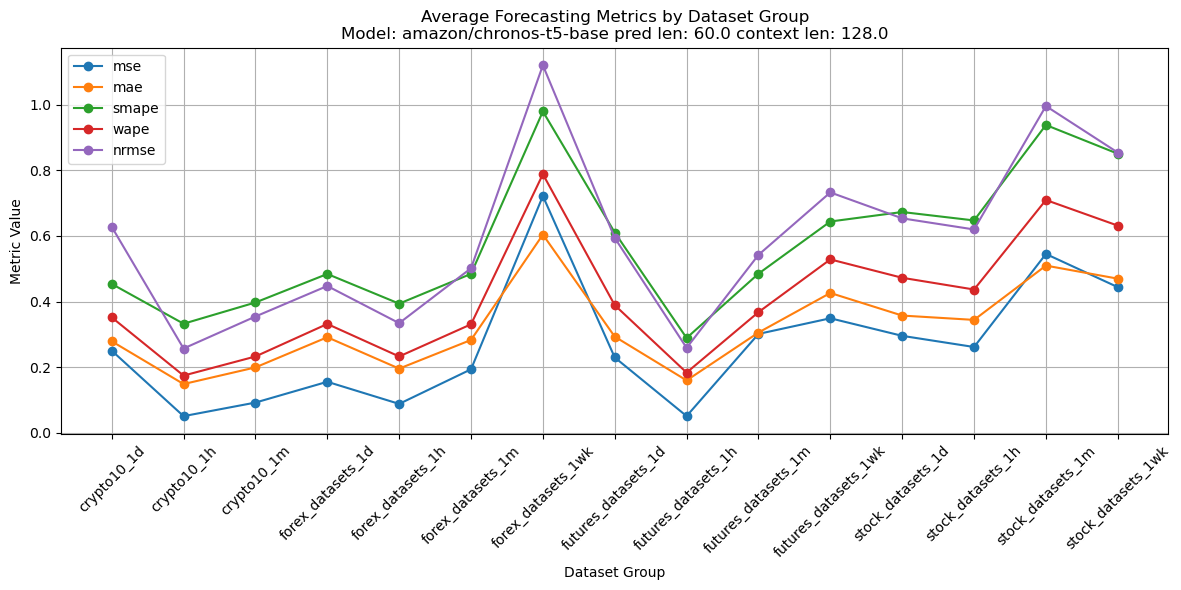


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=MSE
✅ Filled 'Chronos Medium' (pred_len=60) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: mse

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.053624  0.215265  0.115258  0.145289  0.279531   3173.333333   
1   0.009456  0.165440  0.062387  0.073022  0.112159  20360.000000   
2   0.011496  0.171012  0.068184  0.078989  0.124161   8333.333333   
3   0.033551  0.242081  0.129841  0.146913  0.206833   6420.000000   
4   0.015055  0.184692  0.077483  0.091728  0.139786  20226.666667   
5   0.036026  0.245128  0.120608  0.140803  0.209165  11680.000000   
6   0.222757  0.622518  0.312019  0.408058  0.629523   1520.000000   
7   0.040137  0.345620  0.124867  0.163803  0.246874   6760.000000   
8   0.012065  0.157751  0.070678  0.081308  0.126360  15640.000000   
9   0.226620  0.311149  0.196459  0.240336  0.375096   8633.333333   
10  0.104496  0.359801  0.236907  0.285400  0.389425   1520.000000   
11  0.063516  0.358005  0.153236  0.200863  0.293982   6329.270386   
12  0.056603  0.348820  0.149625  0.188969  0.285588   5197.000000   
13  0.136943  0.521139  0.227826  0.310649  0.486598   2496.752137   
14  0.119781  0.474752  0.222897  0.290041  0.420871   1828.705882   

         abs_sum  total_time  pred_len  context_len                 group  
0    2622.283529   12.707186      10.0        128.0           crypto10_1d  
1   17353.266602   77.963964      10.0        128.0           crypto10_1h  
2    7184.560872   30.805048      10.0        128.0           crypto10_1m  
3    5675.617920   23.870467      10.0        128.0     forex_datasets_1d  
4   17314.160807   74.239986      10.0        128.0     forex_datasets_1h  
5   10106.773763   42.914597      10.0        128.0     forex_datasets_1m  
6    1196.905497    5.741751      10.0        128.0    forex_datasets_1wk  
7    5121.516357   24.944983      10.0        128.0   futures_datasets_1d  
8   13595.334961   57.833095      10.0        128.0   futures_datasets_1h  
9    7449.247111   31.661694      10.0        128.0   futures_datasets_1m  
10   1261.736206    5.843038      10.0        128.0  futures_datasets_1wk  
11   5063.375805   23.149468      10.0        128.0     stock_datasets_1d  
12   4207.023304   19.124253      10.0        128.0     stock_datasets_1h  
13   1876.309469    9.184666      10.0        128.0     stock_datasets_1m  
14   1425.855316    6.760370      10.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.0761
smape              0.3149
mae                0.1512
wape               0.1897
nrmse              0.2884
num_elements    8007.8930
abs_sum         6763.5978
total_time        29.7830
pred_len          10.0000
context_len      128.0000
dtype: float64


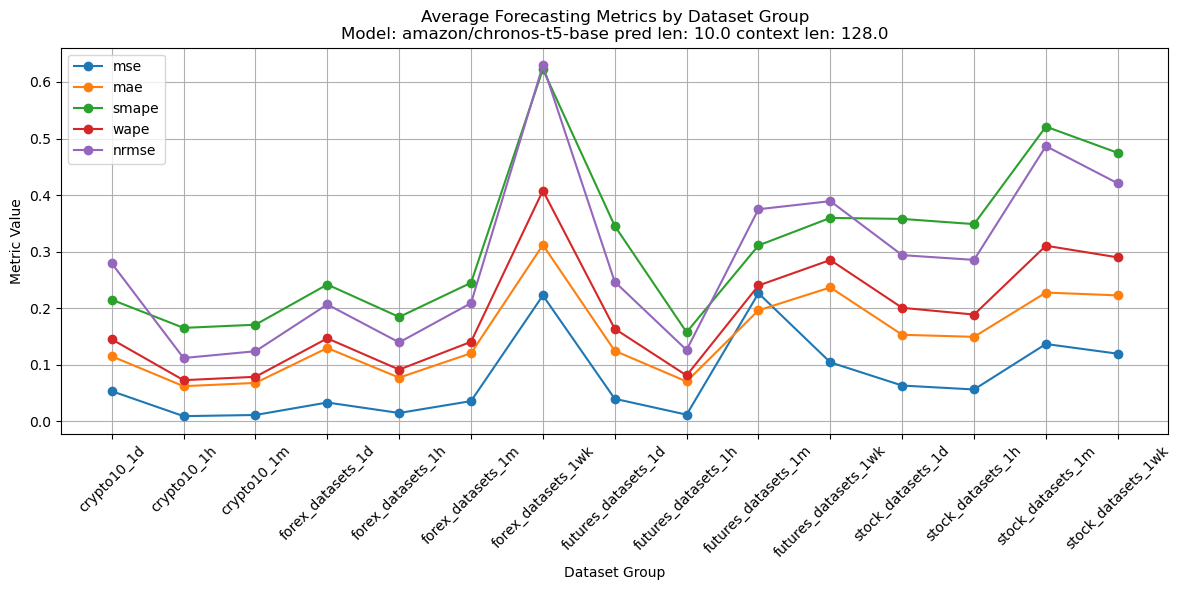


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=MAE
✅ Filled 'Chronos Medium' (pred_len=10) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: mae

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.087312  0.280281  0.152936  0.191467  0.361989   3173.333333   
1   0.018418  0.218928  0.089994  0.105382  0.156320  20320.000000   
2   0.024810  0.243412  0.100144  0.116643  0.183470   8293.333333   
3   0.060883  0.308675  0.172666  0.195584  0.277265   6400.000000   
4   0.029456  0.245448  0.110582  0.131102  0.194371  20213.333333   
5   0.066490  0.318125  0.166886  0.194656  0.289240  11680.000000   
6   0.374573  0.759461  0.430768  0.561295  0.811805   1520.000000   
7   0.068766  0.428529  0.166522  0.218527  0.325556   6760.000000   
8   0.020311  0.201536  0.098653  0.113432  0.163867  15600.000000   
9   0.244001  0.371405  0.231191  0.281210  0.426030   8626.666667   
10  0.156739  0.437424  0.290482  0.349941  0.476940   1520.000000   
11  0.110961  0.450892  0.208619  0.273143  0.391304   6315.879828   
12  0.104379  0.442198  0.206947  0.262442  0.390144   5163.666667   
13  0.269906  0.659430  0.321957  0.442508  0.688412   2474.188034   
14  0.202016  0.589165  0.296535  0.386554  0.548208   1821.176471   

         abs_sum  total_time  pred_len  context_len                 group  
0    2622.283936   10.954636      20.0        128.0           crypto10_1d  
1   17313.417969   69.238795      20.0        128.0           crypto10_1h  
2    7123.527507   28.246483      20.0        128.0           crypto10_1m  
3    5655.123047   22.082682      20.0        128.0     forex_datasets_1d  
4   17302.552083   68.413620      20.0        128.0     forex_datasets_1h  
5   10106.771484   39.869170      20.0        128.0     forex_datasets_1m  
6    1196.905538    5.300640      20.0        128.0    forex_datasets_1wk  
7    5121.516602   23.066282      20.0        128.0   futures_datasets_1d  
8   13567.410156   53.387169      20.0        128.0   futures_datasets_1h  
9    7438.841838   29.367866      20.0        128.0   futures_datasets_1m  
10   1261.736206    5.502228      20.0        128.0  futures_datasets_1wk  
11   5045.140767   21.194611      20.0        128.0     stock_datasets_1d  
12   4163.177339   17.270096      20.0        128.0     stock_datasets_1h  
13   1848.851493    8.300601      20.0        128.0     stock_datasets_1m  
14   1413.295853    6.122761      20.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.1226
smape              0.3970
mae                0.2030
wape               0.2549
nrmse              0.3790
num_elements    7992.1052
abs_sum         6745.3701
total_time        27.2212
pred_len          20.0000
context_len      128.0000
dtype: float64


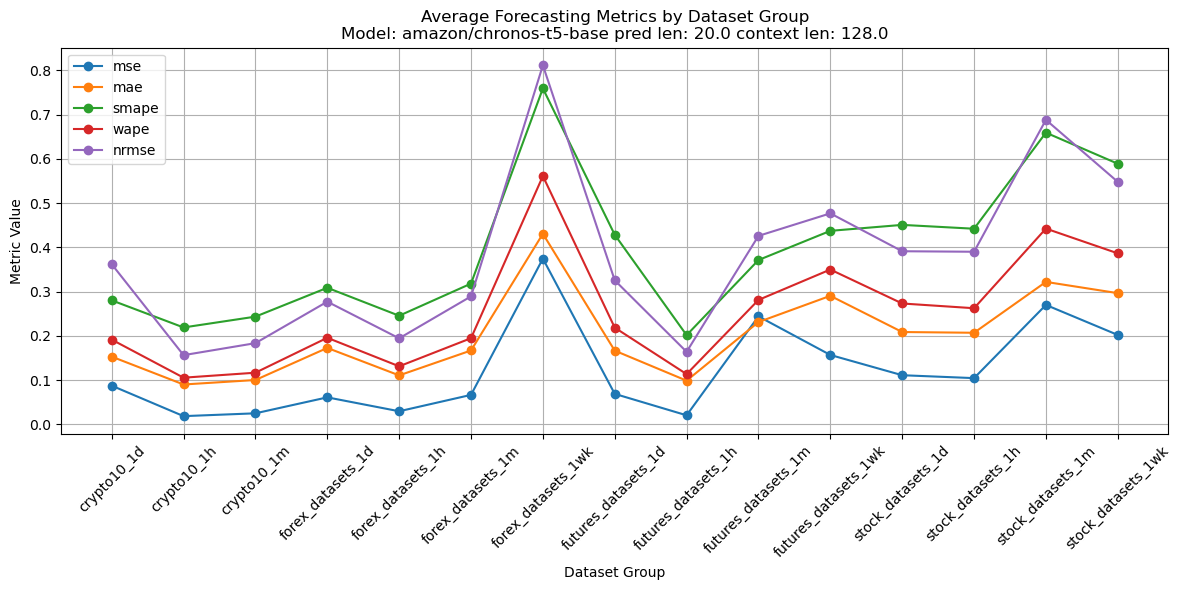


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=MAE
✅ Filled 'Chronos Medium' (pred_len=20) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: mae

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.138484  0.327624  0.193239  0.243750  0.460921   3120.000000   
1   0.024730  0.250653  0.105444  0.123557  0.180662  20280.000000   
2   0.043907  0.288132  0.133096  0.155084  0.242825   8280.000000   
3   0.089522  0.382582  0.222182  0.251604  0.335276   6360.000000   
4   0.041786  0.290885  0.135661  0.161289  0.234440  20160.000000   
5   0.092907  0.361713  0.200457  0.233680  0.345873  11640.000000   
6   0.388735  0.786881  0.435010  0.578279  0.835189   1440.000000   
7   0.103577  0.504710  0.205870  0.270992  0.396926   6720.000000   
8   0.031607  0.257145  0.125619  0.144438  0.204419  15600.000000   
9   0.260469  0.410703  0.254724  0.309146  0.462246   8580.000000   
10  0.211026  0.549855  0.335453  0.416046  0.569741   1440.000000   
11  0.164940  0.528453  0.256733  0.338191  0.480625   6282.746781   
12  0.149158  0.509141  0.250859  0.317585  0.464735   5163.500000   
13  0.308858  0.737657  0.364811  0.505015  0.740988   2445.641026   
14  0.278204  0.674081  0.354181  0.471722  0.656391   1766.823529   

         abs_sum  total_time  pred_len  context_len                 group  
0    2559.130046   10.494509      30.0        128.0           crypto10_1d  
1   17267.364258   67.066345      30.0        128.0           crypto10_1h  
2    7102.145345   27.458822      30.0        128.0           crypto10_1m  
3    5625.184814   21.325132      30.0        128.0     forex_datasets_1d  
4   17212.069661   66.109466      30.0        128.0     forex_datasets_1h  
5   10062.485677   38.503162      30.0        128.0     forex_datasets_1m  
6    1117.053060    4.923247      30.0        128.0    forex_datasets_1wk  
7    5068.270996   22.299176      30.0        128.0   futures_datasets_1d  
8   13567.412109   52.102547      30.0        128.0   futures_datasets_1h  
9    7389.731608   28.339815      30.0        128.0   futures_datasets_1m  
10   1161.055664    5.075302      30.0        128.0  futures_datasets_1wk  
11   5008.751638   20.498755      30.0        128.0     stock_datasets_1d  
12   4168.045179   16.864363      30.0        128.0     stock_datasets_1h  
13   1808.626365    7.998626      30.0        128.0     stock_datasets_1m  
14   1343.625452    5.776524      30.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.1552
smape              0.4573
mae                0.2382
wape               0.3014
nrmse              0.4408
num_elements    7951.9141
abs_sum         6697.3968
total_time        26.3224
pred_len          30.0000
context_len      128.0000
dtype: float64


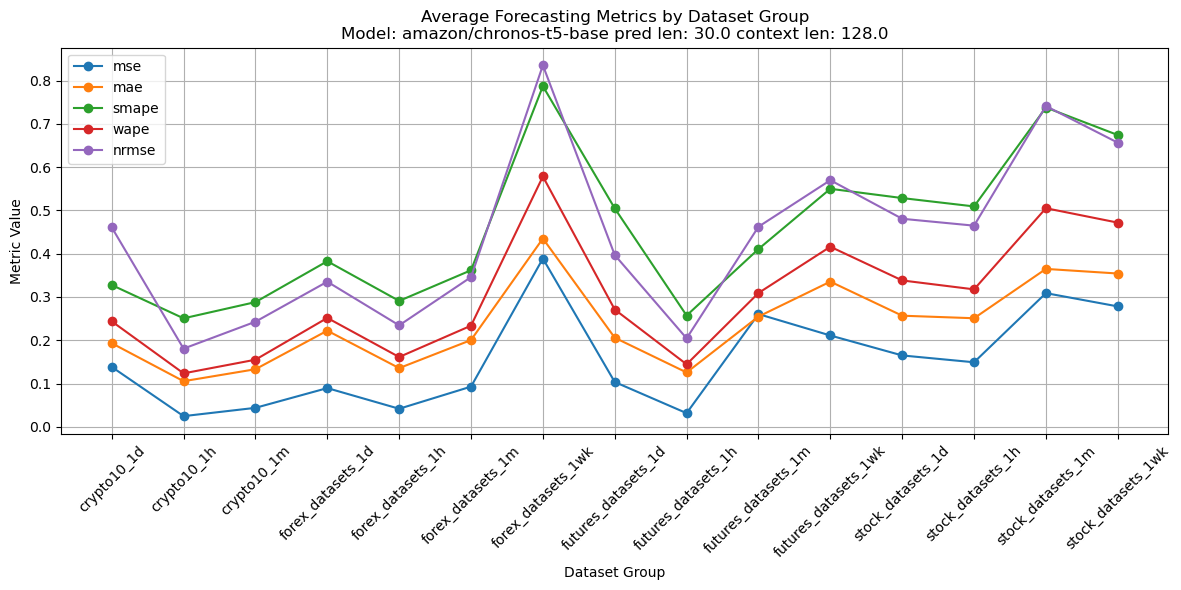


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=MAE
✅ Filled 'Chronos Medium' (pred_len=30) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: mae

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.250216  0.453631  0.278767  0.351668  0.627806   3120.000000   
1   0.050495  0.332269  0.148321  0.174149  0.256700  20160.000000   
2   0.091866  0.396997  0.199059  0.232405  0.354221   8240.000000   
3   0.155244  0.483940  0.291053  0.331533  0.447304   6240.000000   
4   0.087859  0.393457  0.195392  0.232441  0.333968  20080.000000   
5   0.193314  0.484268  0.282717  0.330474  0.501328  11520.000000   
6   0.721485  0.979455  0.603891  0.788140  1.120183   1440.000000   
7   0.229425  0.610338  0.292865  0.388836  0.593901   6600.000000   
8   0.050622  0.288742  0.159396  0.183275  0.258700  15600.000000   
9   0.301169  0.484777  0.305360  0.367516  0.542156   8520.000000   
10  0.348858  0.643870  0.426013  0.528362  0.732544   1440.000000   
11  0.295300  0.672839  0.357116  0.472313  0.653507   6237.939914   
12  0.261253  0.647109  0.343926  0.436536  0.619640   5124.000000   
13  0.544892  0.938108  0.509478  0.709443  0.995843   2416.410256   
14  0.443772  0.850564  0.469621  0.631354  0.854157   1743.529412   

         abs_sum  total_time  pred_len  context_len                 group  
0    2559.130086   10.512485      60.0        128.0           crypto10_1d  
1   17140.966797   66.669837      60.0        128.0           crypto10_1h  
2    7039.945150   27.403459      60.0        128.0           crypto10_1m  
3    5487.800781   20.923788      60.0        128.0     forex_datasets_1d  
4   17142.236979   66.115750      60.0        128.0     forex_datasets_1h  
5    9928.854167   38.226665      60.0        128.0     forex_datasets_1m  
6    1117.053141    4.938406      60.0        128.0    forex_datasets_1wk  
7    4909.750000   22.100742      60.0        128.0   futures_datasets_1d  
8   13567.413086   52.223918      60.0        128.0   futures_datasets_1h  
9    7337.163656   28.141163      60.0        128.0   futures_datasets_1m  
10   1161.055664    5.082750      60.0        128.0  futures_datasets_1wk  
11   4942.476508   20.607203      60.0        128.0     stock_datasets_1d  
12   4125.142122   16.976611      60.0        128.0     stock_datasets_1h  
13   1778.563307    7.989278      60.0        128.0     stock_datasets_1m  
14   1306.227279    5.769339      60.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.2684
smape              0.5774
mae                0.3242
wape               0.4106
nrmse              0.5928
num_elements    7898.7920
abs_sum         6636.2519
total_time        26.2454
pred_len          60.0000
context_len      128.0000
dtype: float64


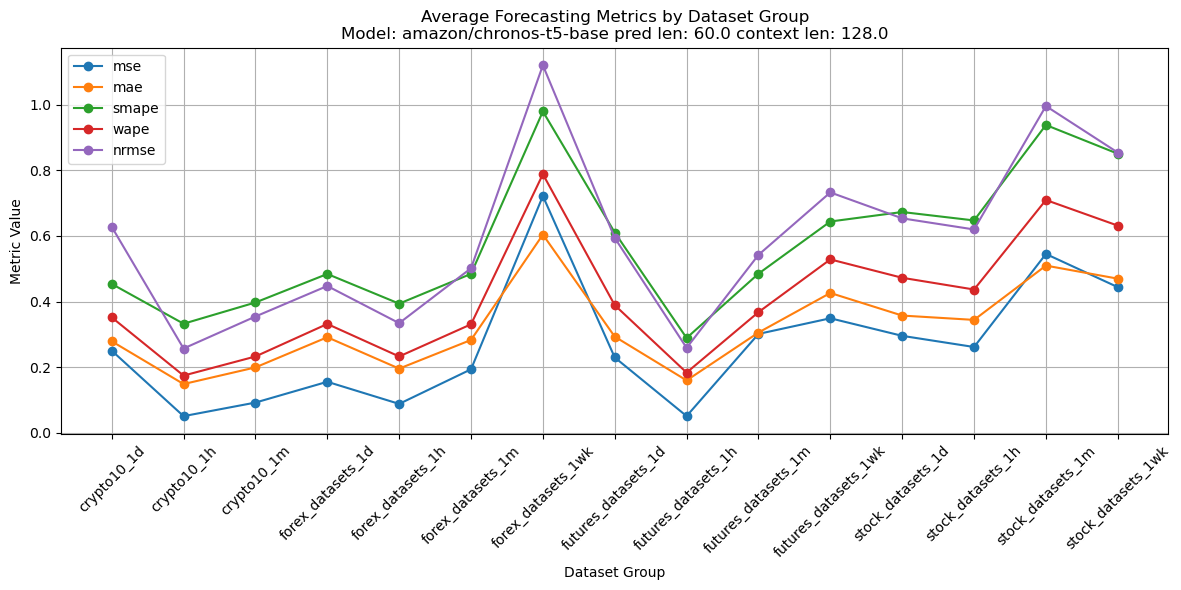


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=MAE
✅ Filled 'Chronos Medium' (pred_len=60) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: mae

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.053624  0.215265  0.115258  0.145289  0.279531   3173.333333   
1   0.009456  0.165440  0.062387  0.073022  0.112159  20360.000000   
2   0.011496  0.171012  0.068184  0.078989  0.124161   8333.333333   
3   0.033551  0.242081  0.129841  0.146913  0.206833   6420.000000   
4   0.015055  0.184692  0.077483  0.091728  0.139786  20226.666667   
5   0.036026  0.245128  0.120608  0.140803  0.209165  11680.000000   
6   0.222757  0.622518  0.312019  0.408058  0.629523   1520.000000   
7   0.040137  0.345620  0.124867  0.163803  0.246874   6760.000000   
8   0.012065  0.157751  0.070678  0.081308  0.126360  15640.000000   
9   0.226620  0.311149  0.196459  0.240336  0.375096   8633.333333   
10  0.104496  0.359801  0.236907  0.285400  0.389425   1520.000000   
11  0.063516  0.358005  0.153236  0.200863  0.293982   6329.270386   
12  0.056603  0.348820  0.149625  0.188969  0.285588   5197.000000   
13  0.136943  0.521139  0.227826  0.310649  0.486598   2496.752137   
14  0.119781  0.474752  0.222897  0.290041  0.420871   1828.705882   

         abs_sum  total_time  pred_len  context_len                 group  
0    2622.283529   12.707186      10.0        128.0           crypto10_1d  
1   17353.266602   77.963964      10.0        128.0           crypto10_1h  
2    7184.560872   30.805048      10.0        128.0           crypto10_1m  
3    5675.617920   23.870467      10.0        128.0     forex_datasets_1d  
4   17314.160807   74.239986      10.0        128.0     forex_datasets_1h  
5   10106.773763   42.914597      10.0        128.0     forex_datasets_1m  
6    1196.905497    5.741751      10.0        128.0    forex_datasets_1wk  
7    5121.516357   24.944983      10.0        128.0   futures_datasets_1d  
8   13595.334961   57.833095      10.0        128.0   futures_datasets_1h  
9    7449.247111   31.661694      10.0        128.0   futures_datasets_1m  
10   1261.736206    5.843038      10.0        128.0  futures_datasets_1wk  
11   5063.375805   23.149468      10.0        128.0     stock_datasets_1d  
12   4207.023304   19.124253      10.0        128.0     stock_datasets_1h  
13   1876.309469    9.184666      10.0        128.0     stock_datasets_1m  
14   1425.855316    6.760370      10.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.0761
smape              0.3149
mae                0.1512
wape               0.1897
nrmse              0.2884
num_elements    8007.8930
abs_sum         6763.5978
total_time        29.7830
pred_len          10.0000
context_len      128.0000
dtype: float64


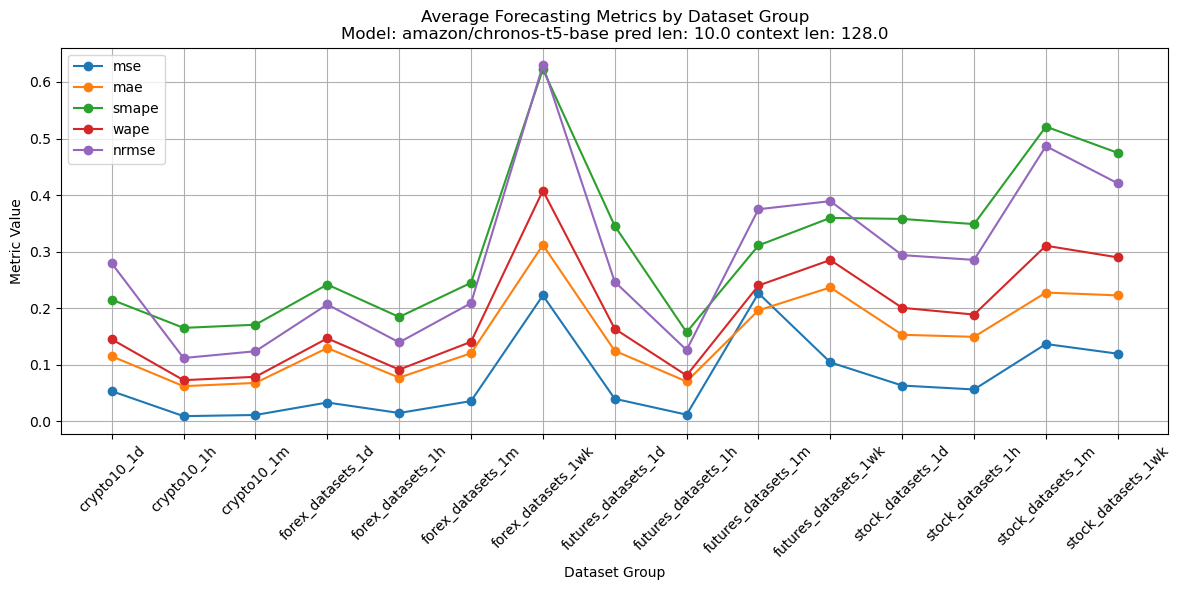


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=SMAPE
✅ Filled 'Chronos Medium' (pred_len=10) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: smape

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.087312  0.280281  0.152936  0.191467  0.361989   3173.333333   
1   0.018418  0.218928  0.089994  0.105382  0.156320  20320.000000   
2   0.024810  0.243412  0.100144  0.116643  0.183470   8293.333333   
3   0.060883  0.308675  0.172666  0.195584  0.277265   6400.000000   
4   0.029456  0.245448  0.110582  0.131102  0.194371  20213.333333   
5   0.066490  0.318125  0.166886  0.194656  0.289240  11680.000000   
6   0.374573  0.759461  0.430768  0.561295  0.811805   1520.000000   
7   0.068766  0.428529  0.166522  0.218527  0.325556   6760.000000   
8   0.020311  0.201536  0.098653  0.113432  0.163867  15600.000000   
9   0.244001  0.371405  0.231191  0.281210  0.426030   8626.666667   
10  0.156739  0.437424  0.290482  0.349941  0.476940   1520.000000   
11  0.110961  0.450892  0.208619  0.273143  0.391304   6315.879828   
12  0.104379  0.442198  0.206947  0.262442  0.390144   5163.666667   
13  0.269906  0.659430  0.321957  0.442508  0.688412   2474.188034   
14  0.202016  0.589165  0.296535  0.386554  0.548208   1821.176471   

         abs_sum  total_time  pred_len  context_len                 group  
0    2622.283936   10.954636      20.0        128.0           crypto10_1d  
1   17313.417969   69.238795      20.0        128.0           crypto10_1h  
2    7123.527507   28.246483      20.0        128.0           crypto10_1m  
3    5655.123047   22.082682      20.0        128.0     forex_datasets_1d  
4   17302.552083   68.413620      20.0        128.0     forex_datasets_1h  
5   10106.771484   39.869170      20.0        128.0     forex_datasets_1m  
6    1196.905538    5.300640      20.0        128.0    forex_datasets_1wk  
7    5121.516602   23.066282      20.0        128.0   futures_datasets_1d  
8   13567.410156   53.387169      20.0        128.0   futures_datasets_1h  
9    7438.841838   29.367866      20.0        128.0   futures_datasets_1m  
10   1261.736206    5.502228      20.0        128.0  futures_datasets_1wk  
11   5045.140767   21.194611      20.0        128.0     stock_datasets_1d  
12   4163.177339   17.270096      20.0        128.0     stock_datasets_1h  
13   1848.851493    8.300601      20.0        128.0     stock_datasets_1m  
14   1413.295853    6.122761      20.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.1226
smape              0.3970
mae                0.2030
wape               0.2549
nrmse              0.3790
num_elements    7992.1052
abs_sum         6745.3701
total_time        27.2212
pred_len          20.0000
context_len      128.0000
dtype: float64


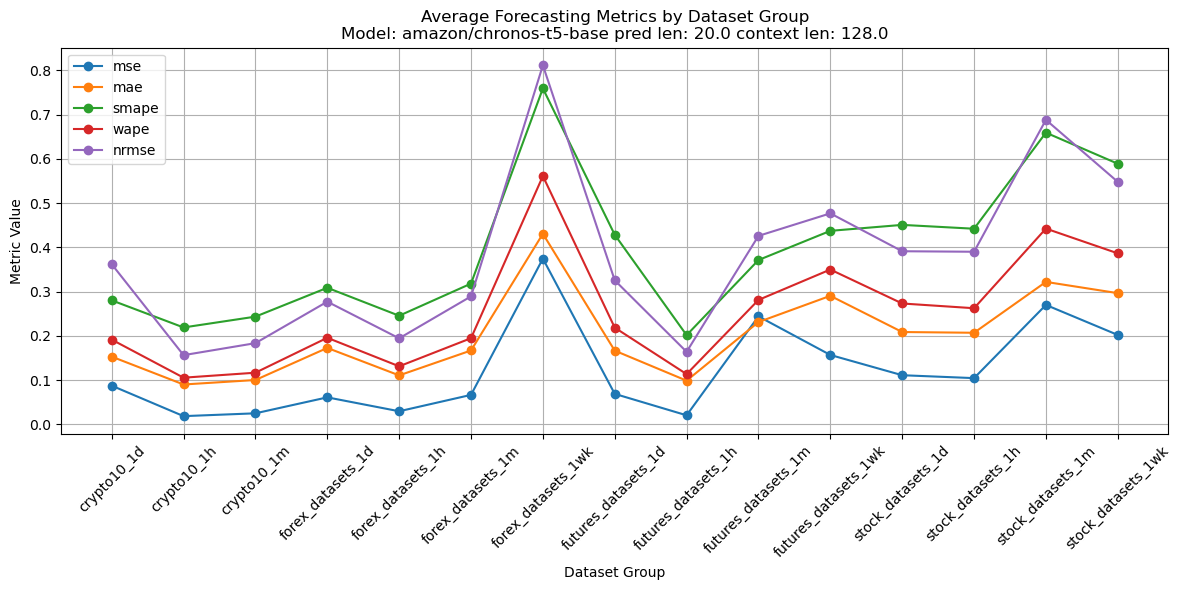


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=SMAPE
✅ Filled 'Chronos Medium' (pred_len=20) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: smape

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.138484  0.327624  0.193239  0.243750  0.460921   3120.000000   
1   0.024730  0.250653  0.105444  0.123557  0.180662  20280.000000   
2   0.043907  0.288132  0.133096  0.155084  0.242825   8280.000000   
3   0.089522  0.382582  0.222182  0.251604  0.335276   6360.000000   
4   0.041786  0.290885  0.135661  0.161289  0.234440  20160.000000   
5   0.092907  0.361713  0.200457  0.233680  0.345873  11640.000000   
6   0.388735  0.786881  0.435010  0.578279  0.835189   1440.000000   
7   0.103577  0.504710  0.205870  0.270992  0.396926   6720.000000   
8   0.031607  0.257145  0.125619  0.144438  0.204419  15600.000000   
9   0.260469  0.410703  0.254724  0.309146  0.462246   8580.000000   
10  0.211026  0.549855  0.335453  0.416046  0.569741   1440.000000   
11  0.164940  0.528453  0.256733  0.338191  0.480625   6282.746781   
12  0.149158  0.509141  0.250859  0.317585  0.464735   5163.500000   
13  0.308858  0.737657  0.364811  0.505015  0.740988   2445.641026   
14  0.278204  0.674081  0.354181  0.471722  0.656391   1766.823529   

         abs_sum  total_time  pred_len  context_len                 group  
0    2559.130046   10.494509      30.0        128.0           crypto10_1d  
1   17267.364258   67.066345      30.0        128.0           crypto10_1h  
2    7102.145345   27.458822      30.0        128.0           crypto10_1m  
3    5625.184814   21.325132      30.0        128.0     forex_datasets_1d  
4   17212.069661   66.109466      30.0        128.0     forex_datasets_1h  
5   10062.485677   38.503162      30.0        128.0     forex_datasets_1m  
6    1117.053060    4.923247      30.0        128.0    forex_datasets_1wk  
7    5068.270996   22.299176      30.0        128.0   futures_datasets_1d  
8   13567.412109   52.102547      30.0        128.0   futures_datasets_1h  
9    7389.731608   28.339815      30.0        128.0   futures_datasets_1m  
10   1161.055664    5.075302      30.0        128.0  futures_datasets_1wk  
11   5008.751638   20.498755      30.0        128.0     stock_datasets_1d  
12   4168.045179   16.864363      30.0        128.0     stock_datasets_1h  
13   1808.626365    7.998626      30.0        128.0     stock_datasets_1m  
14   1343.625452    5.776524      30.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.1552
smape              0.4573
mae                0.2382
wape               0.3014
nrmse              0.4408
num_elements    7951.9141
abs_sum         6697.3968
total_time        26.3224
pred_len          30.0000
context_len      128.0000
dtype: float64


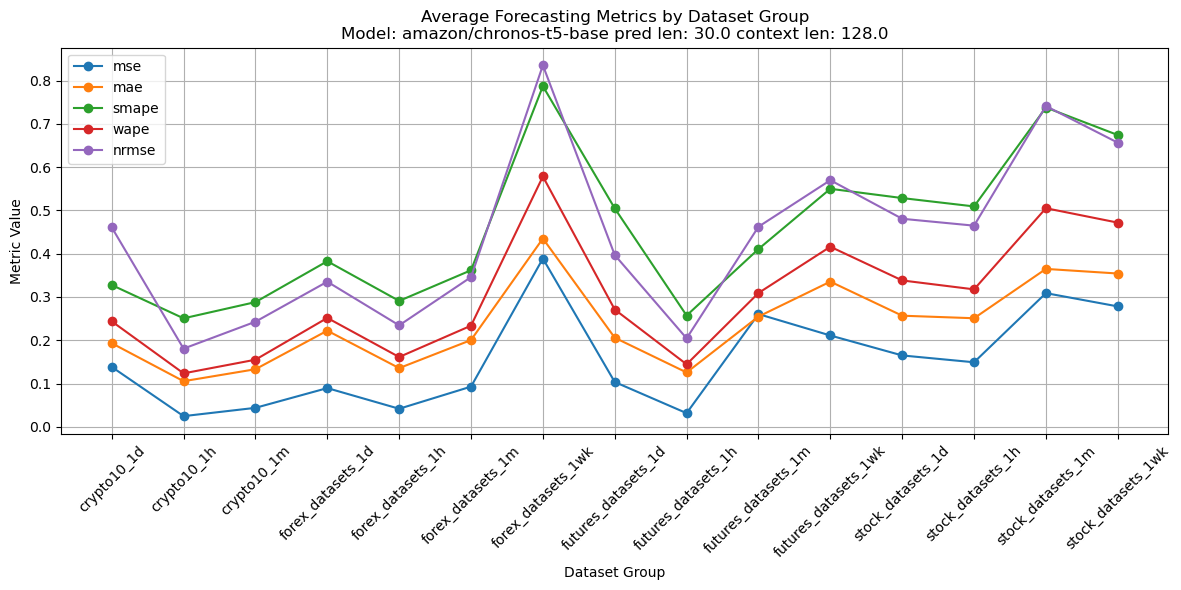


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=SMAPE
✅ Filled 'Chronos Medium' (pred_len=30) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: smape

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.250216  0.453631  0.278767  0.351668  0.627806   3120.000000   
1   0.050495  0.332269  0.148321  0.174149  0.256700  20160.000000   
2   0.091866  0.396997  0.199059  0.232405  0.354221   8240.000000   
3   0.155244  0.483940  0.291053  0.331533  0.447304   6240.000000   
4   0.087859  0.393457  0.195392  0.232441  0.333968  20080.000000   
5   0.193314  0.484268  0.282717  0.330474  0.501328  11520.000000   
6   0.721485  0.979455  0.603891  0.788140  1.120183   1440.000000   
7   0.229425  0.610338  0.292865  0.388836  0.593901   6600.000000   
8   0.050622  0.288742  0.159396  0.183275  0.258700  15600.000000   
9   0.301169  0.484777  0.305360  0.367516  0.542156   8520.000000   
10  0.348858  0.643870  0.426013  0.528362  0.732544   1440.000000   
11  0.295300  0.672839  0.357116  0.472313  0.653507   6237.939914   
12  0.261253  0.647109  0.343926  0.436536  0.619640   5124.000000   
13  0.544892  0.938108  0.509478  0.709443  0.995843   2416.410256   
14  0.443772  0.850564  0.469621  0.631354  0.854157   1743.529412   

         abs_sum  total_time  pred_len  context_len                 group  
0    2559.130086   10.512485      60.0        128.0           crypto10_1d  
1   17140.966797   66.669837      60.0        128.0           crypto10_1h  
2    7039.945150   27.403459      60.0        128.0           crypto10_1m  
3    5487.800781   20.923788      60.0        128.0     forex_datasets_1d  
4   17142.236979   66.115750      60.0        128.0     forex_datasets_1h  
5    9928.854167   38.226665      60.0        128.0     forex_datasets_1m  
6    1117.053141    4.938406      60.0        128.0    forex_datasets_1wk  
7    4909.750000   22.100742      60.0        128.0   futures_datasets_1d  
8   13567.413086   52.223918      60.0        128.0   futures_datasets_1h  
9    7337.163656   28.141163      60.0        128.0   futures_datasets_1m  
10   1161.055664    5.082750      60.0        128.0  futures_datasets_1wk  
11   4942.476508   20.607203      60.0        128.0     stock_datasets_1d  
12   4125.142122   16.976611      60.0        128.0     stock_datasets_1h  
13   1778.563307    7.989278      60.0        128.0     stock_datasets_1m  
14   1306.227279    5.769339      60.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.2684
smape              0.5774
mae                0.3242
wape               0.4106
nrmse              0.5928
num_elements    7898.7920
abs_sum         6636.2519
total_time        26.2454
pred_len          60.0000
context_len      128.0000
dtype: float64


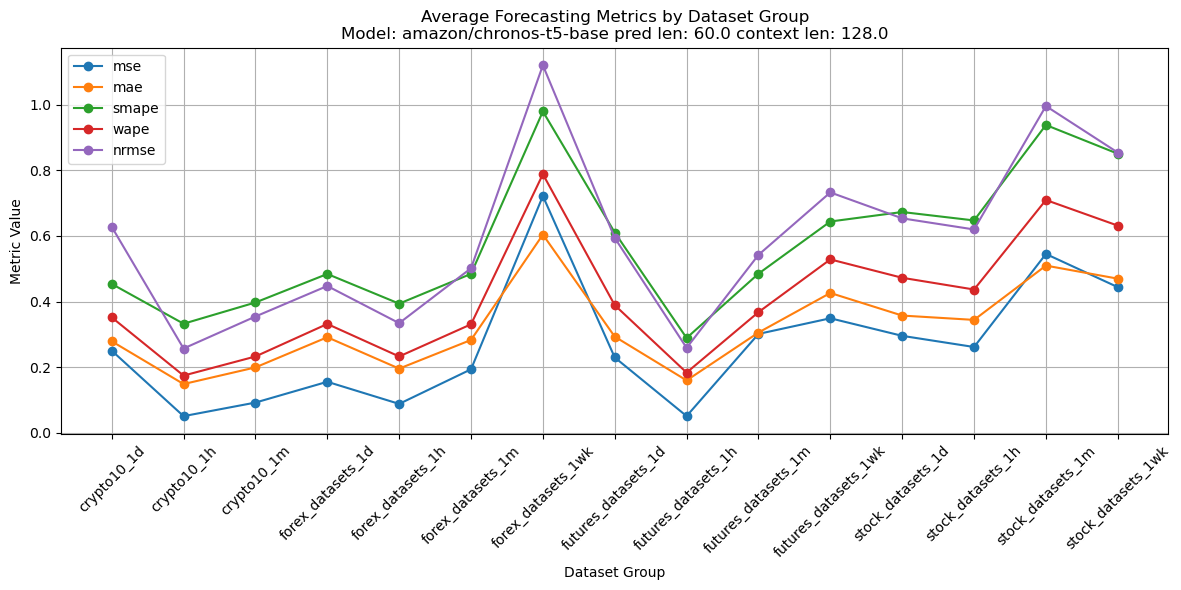


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=SMAPE
✅ Filled 'Chronos Medium' (pred_len=60) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: smape

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.053624  0.215265  0.115258  0.145289  0.279531   3173.333333   
1   0.009456  0.165440  0.062387  0.073022  0.112159  20360.000000   
2   0.011496  0.171012  0.068184  0.078989  0.124161   8333.333333   
3   0.033551  0.242081  0.129841  0.146913  0.206833   6420.000000   
4   0.015055  0.184692  0.077483  0.091728  0.139786  20226.666667   
5   0.036026  0.245128  0.120608  0.140803  0.209165  11680.000000   
6   0.222757  0.622518  0.312019  0.408058  0.629523   1520.000000   
7   0.040137  0.345620  0.124867  0.163803  0.246874   6760.000000   
8   0.012065  0.157751  0.070678  0.081308  0.126360  15640.000000   
9   0.226620  0.311149  0.196459  0.240336  0.375096   8633.333333   
10  0.104496  0.359801  0.236907  0.285400  0.389425   1520.000000   
11  0.063516  0.358005  0.153236  0.200863  0.293982   6329.270386   
12  0.056603  0.348820  0.149625  0.188969  0.285588   5197.000000   
13  0.136943  0.521139  0.227826  0.310649  0.486598   2496.752137   
14  0.119781  0.474752  0.222897  0.290041  0.420871   1828.705882   

         abs_sum  total_time  pred_len  context_len                 group  
0    2622.283529   12.707186      10.0        128.0           crypto10_1d  
1   17353.266602   77.963964      10.0        128.0           crypto10_1h  
2    7184.560872   30.805048      10.0        128.0           crypto10_1m  
3    5675.617920   23.870467      10.0        128.0     forex_datasets_1d  
4   17314.160807   74.239986      10.0        128.0     forex_datasets_1h  
5   10106.773763   42.914597      10.0        128.0     forex_datasets_1m  
6    1196.905497    5.741751      10.0        128.0    forex_datasets_1wk  
7    5121.516357   24.944983      10.0        128.0   futures_datasets_1d  
8   13595.334961   57.833095      10.0        128.0   futures_datasets_1h  
9    7449.247111   31.661694      10.0        128.0   futures_datasets_1m  
10   1261.736206    5.843038      10.0        128.0  futures_datasets_1wk  
11   5063.375805   23.149468      10.0        128.0     stock_datasets_1d  
12   4207.023304   19.124253      10.0        128.0     stock_datasets_1h  
13   1876.309469    9.184666      10.0        128.0     stock_datasets_1m  
14   1425.855316    6.760370      10.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.0761
smape              0.3149
mae                0.1512
wape               0.1897
nrmse              0.2884
num_elements    8007.8930
abs_sum         6763.5978
total_time        29.7830
pred_len          10.0000
context_len      128.0000
dtype: float64


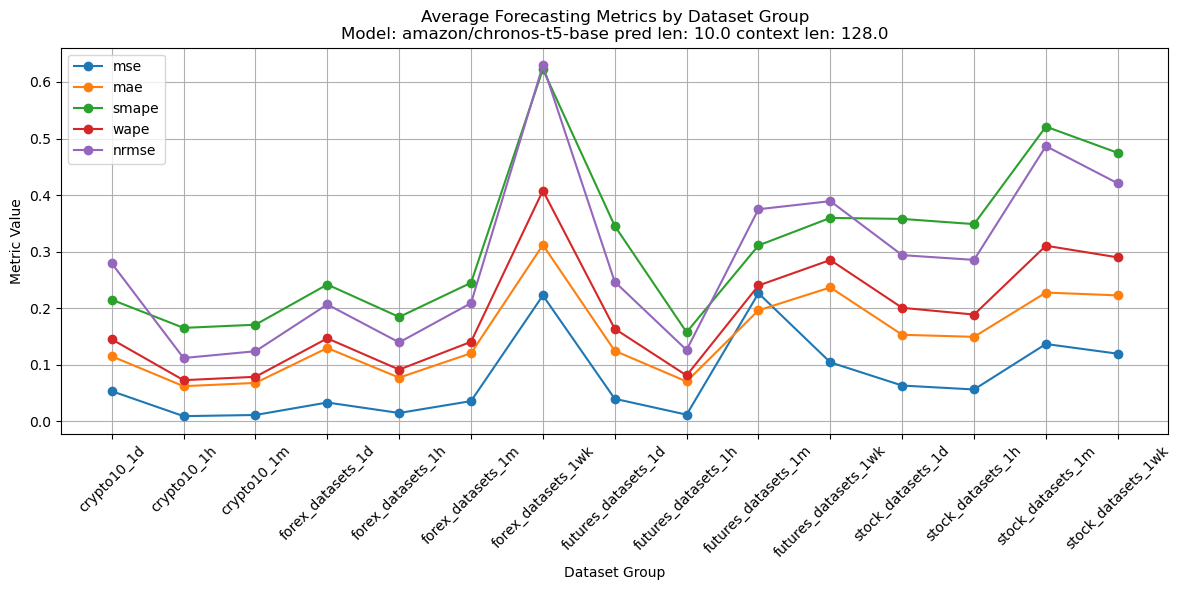


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=WAPE
✅ Filled 'Chronos Medium' (pred_len=10) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: wape

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.087312  0.280281  0.152936  0.191467  0.361989   3173.333333   
1   0.018418  0.218928  0.089994  0.105382  0.156320  20320.000000   
2   0.024810  0.243412  0.100144  0.116643  0.183470   8293.333333   
3   0.060883  0.308675  0.172666  0.195584  0.277265   6400.000000   
4   0.029456  0.245448  0.110582  0.131102  0.194371  20213.333333   
5   0.066490  0.318125  0.166886  0.194656  0.289240  11680.000000   
6   0.374573  0.759461  0.430768  0.561295  0.811805   1520.000000   
7   0.068766  0.428529  0.166522  0.218527  0.325556   6760.000000   
8   0.020311  0.201536  0.098653  0.113432  0.163867  15600.000000   
9   0.244001  0.371405  0.231191  0.281210  0.426030   8626.666667   
10  0.156739  0.437424  0.290482  0.349941  0.476940   1520.000000   
11  0.110961  0.450892  0.208619  0.273143  0.391304   6315.879828   
12  0.104379  0.442198  0.206947  0.262442  0.390144   5163.666667   
13  0.269906  0.659430  0.321957  0.442508  0.688412   2474.188034   
14  0.202016  0.589165  0.296535  0.386554  0.548208   1821.176471   

         abs_sum  total_time  pred_len  context_len                 group  
0    2622.283936   10.954636      20.0        128.0           crypto10_1d  
1   17313.417969   69.238795      20.0        128.0           crypto10_1h  
2    7123.527507   28.246483      20.0        128.0           crypto10_1m  
3    5655.123047   22.082682      20.0        128.0     forex_datasets_1d  
4   17302.552083   68.413620      20.0        128.0     forex_datasets_1h  
5   10106.771484   39.869170      20.0        128.0     forex_datasets_1m  
6    1196.905538    5.300640      20.0        128.0    forex_datasets_1wk  
7    5121.516602   23.066282      20.0        128.0   futures_datasets_1d  
8   13567.410156   53.387169      20.0        128.0   futures_datasets_1h  
9    7438.841838   29.367866      20.0        128.0   futures_datasets_1m  
10   1261.736206    5.502228      20.0        128.0  futures_datasets_1wk  
11   5045.140767   21.194611      20.0        128.0     stock_datasets_1d  
12   4163.177339   17.270096      20.0        128.0     stock_datasets_1h  
13   1848.851493    8.300601      20.0        128.0     stock_datasets_1m  
14   1413.295853    6.122761      20.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.1226
smape              0.3970
mae                0.2030
wape               0.2549
nrmse              0.3790
num_elements    7992.1052
abs_sum         6745.3701
total_time        27.2212
pred_len          20.0000
context_len      128.0000
dtype: float64


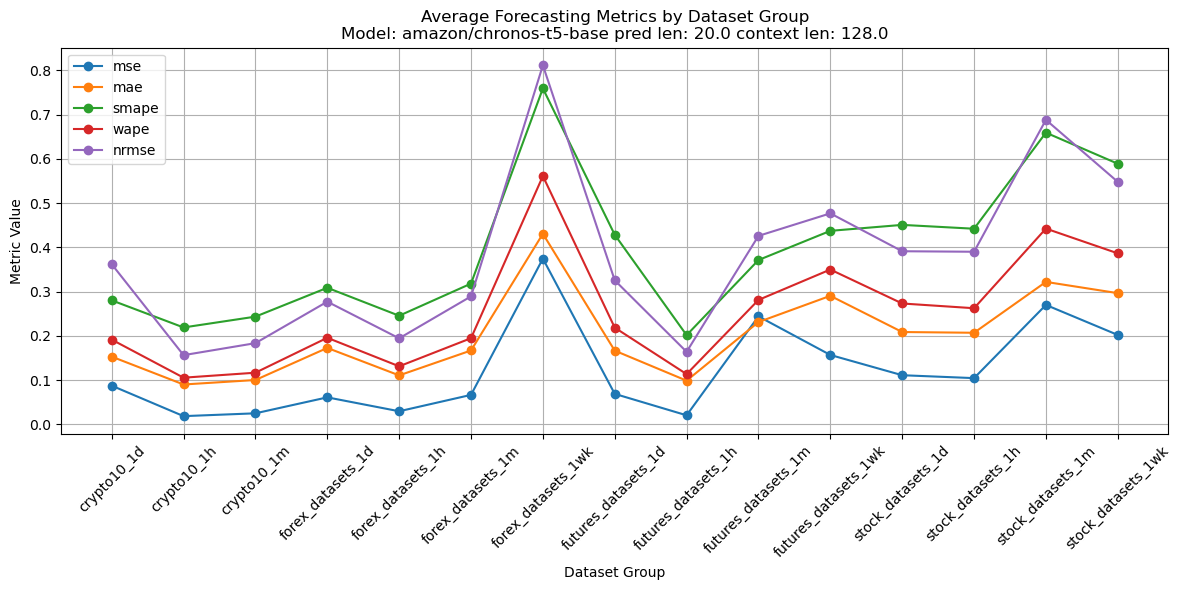


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=WAPE
✅ Filled 'Chronos Medium' (pred_len=20) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: wape

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.138484  0.327624  0.193239  0.243750  0.460921   3120.000000   
1   0.024730  0.250653  0.105444  0.123557  0.180662  20280.000000   
2   0.043907  0.288132  0.133096  0.155084  0.242825   8280.000000   
3   0.089522  0.382582  0.222182  0.251604  0.335276   6360.000000   
4   0.041786  0.290885  0.135661  0.161289  0.234440  20160.000000   
5   0.092907  0.361713  0.200457  0.233680  0.345873  11640.000000   
6   0.388735  0.786881  0.435010  0.578279  0.835189   1440.000000   
7   0.103577  0.504710  0.205870  0.270992  0.396926   6720.000000   
8   0.031607  0.257145  0.125619  0.144438  0.204419  15600.000000   
9   0.260469  0.410703  0.254724  0.309146  0.462246   8580.000000   
10  0.211026  0.549855  0.335453  0.416046  0.569741   1440.000000   
11  0.164940  0.528453  0.256733  0.338191  0.480625   6282.746781   
12  0.149158  0.509141  0.250859  0.317585  0.464735   5163.500000   
13  0.308858  0.737657  0.364811  0.505015  0.740988   2445.641026   
14  0.278204  0.674081  0.354181  0.471722  0.656391   1766.823529   

         abs_sum  total_time  pred_len  context_len                 group  
0    2559.130046   10.494509      30.0        128.0           crypto10_1d  
1   17267.364258   67.066345      30.0        128.0           crypto10_1h  
2    7102.145345   27.458822      30.0        128.0           crypto10_1m  
3    5625.184814   21.325132      30.0        128.0     forex_datasets_1d  
4   17212.069661   66.109466      30.0        128.0     forex_datasets_1h  
5   10062.485677   38.503162      30.0        128.0     forex_datasets_1m  
6    1117.053060    4.923247      30.0        128.0    forex_datasets_1wk  
7    5068.270996   22.299176      30.0        128.0   futures_datasets_1d  
8   13567.412109   52.102547      30.0        128.0   futures_datasets_1h  
9    7389.731608   28.339815      30.0        128.0   futures_datasets_1m  
10   1161.055664    5.075302      30.0        128.0  futures_datasets_1wk  
11   5008.751638   20.498755      30.0        128.0     stock_datasets_1d  
12   4168.045179   16.864363      30.0        128.0     stock_datasets_1h  
13   1808.626365    7.998626      30.0        128.0     stock_datasets_1m  
14   1343.625452    5.776524      30.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.1552
smape              0.4573
mae                0.2382
wape               0.3014
nrmse              0.4408
num_elements    7951.9141
abs_sum         6697.3968
total_time        26.3224
pred_len          30.0000
context_len      128.0000
dtype: float64


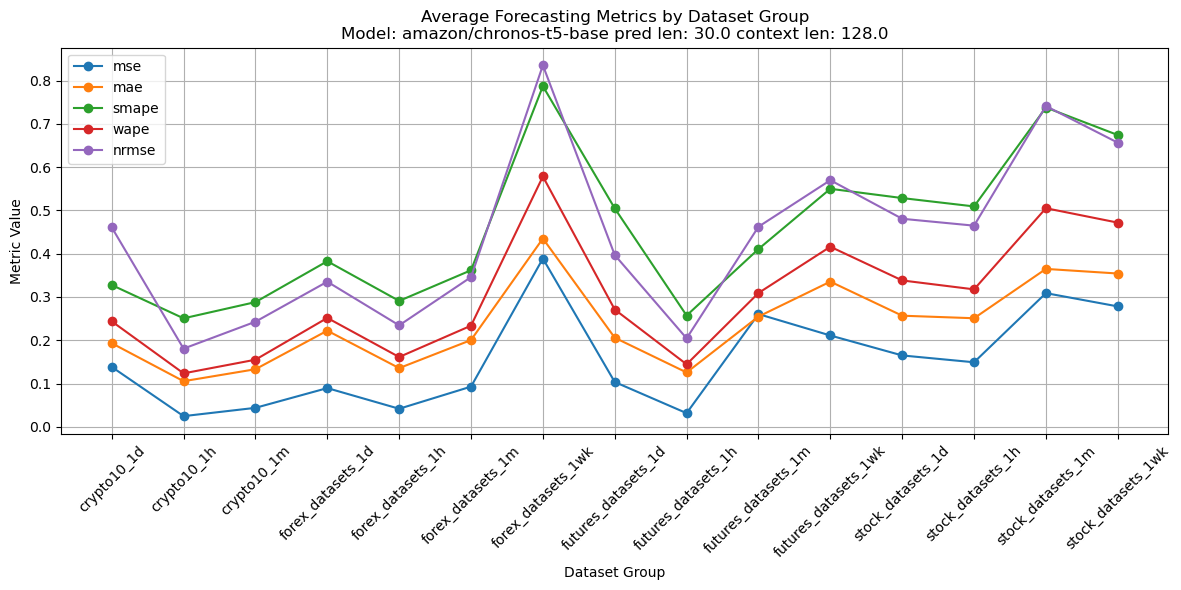


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=WAPE
✅ Filled 'Chronos Medium' (pred_len=30) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: wape

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.250216  0.453631  0.278767  0.351668  0.627806   3120.000000   
1   0.050495  0.332269  0.148321  0.174149  0.256700  20160.000000   
2   0.091866  0.396997  0.199059  0.232405  0.354221   8240.000000   
3   0.155244  0.483940  0.291053  0.331533  0.447304   6240.000000   
4   0.087859  0.393457  0.195392  0.232441  0.333968  20080.000000   
5   0.193314  0.484268  0.282717  0.330474  0.501328  11520.000000   
6   0.721485  0.979455  0.603891  0.788140  1.120183   1440.000000   
7   0.229425  0.610338  0.292865  0.388836  0.593901   6600.000000   
8   0.050622  0.288742  0.159396  0.183275  0.258700  15600.000000   
9   0.301169  0.484777  0.305360  0.367516  0.542156   8520.000000   
10  0.348858  0.643870  0.426013  0.528362  0.732544   1440.000000   
11  0.295300  0.672839  0.357116  0.472313  0.653507   6237.939914   
12  0.261253  0.647109  0.343926  0.436536  0.619640   5124.000000   
13  0.544892  0.938108  0.509478  0.709443  0.995843   2416.410256   
14  0.443772  0.850564  0.469621  0.631354  0.854157   1743.529412   

         abs_sum  total_time  pred_len  context_len                 group  
0    2559.130086   10.512485      60.0        128.0           crypto10_1d  
1   17140.966797   66.669837      60.0        128.0           crypto10_1h  
2    7039.945150   27.403459      60.0        128.0           crypto10_1m  
3    5487.800781   20.923788      60.0        128.0     forex_datasets_1d  
4   17142.236979   66.115750      60.0        128.0     forex_datasets_1h  
5    9928.854167   38.226665      60.0        128.0     forex_datasets_1m  
6    1117.053141    4.938406      60.0        128.0    forex_datasets_1wk  
7    4909.750000   22.100742      60.0        128.0   futures_datasets_1d  
8   13567.413086   52.223918      60.0        128.0   futures_datasets_1h  
9    7337.163656   28.141163      60.0        128.0   futures_datasets_1m  
10   1161.055664    5.082750      60.0        128.0  futures_datasets_1wk  
11   4942.476508   20.607203      60.0        128.0     stock_datasets_1d  
12   4125.142122   16.976611      60.0        128.0     stock_datasets_1h  
13   1778.563307    7.989278      60.0        128.0     stock_datasets_1m  
14   1306.227279    5.769339      60.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.2684
smape              0.5774
mae                0.3242
wape               0.4106
nrmse              0.5928
num_elements    7898.7920
abs_sum         6636.2519
total_time        26.2454
pred_len          60.0000
context_len      128.0000
dtype: float64


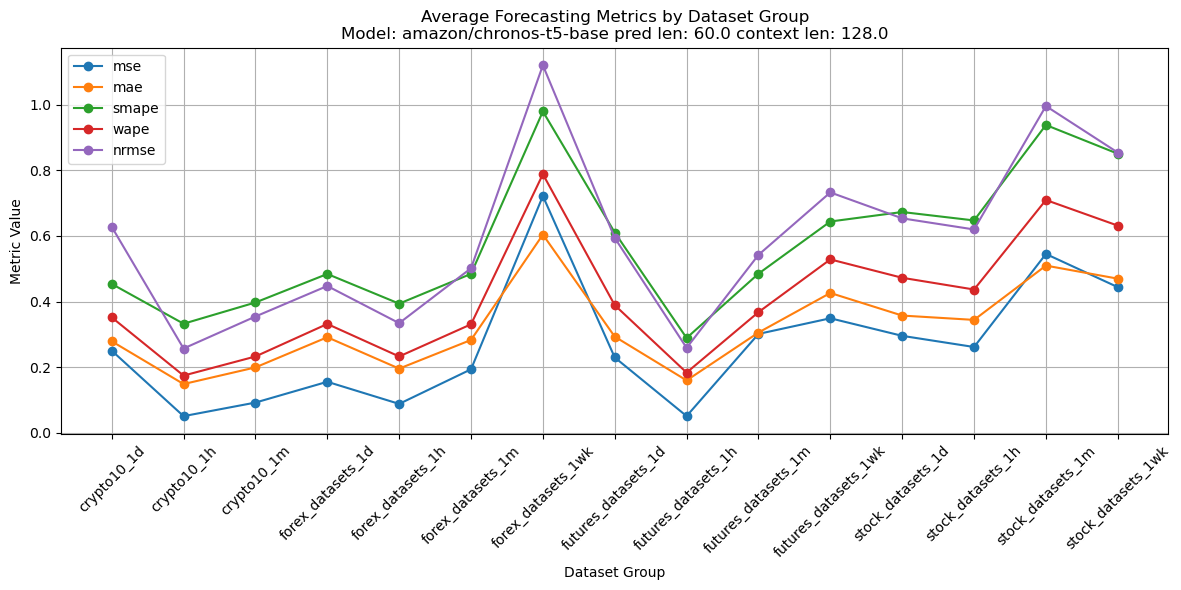


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=WAPE
✅ Filled 'Chronos Medium' (pred_len=60) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: wape

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.053624  0.215265  0.115258  0.145289  0.279531   3173.333333   
1   0.009456  0.165440  0.062387  0.073022  0.112159  20360.000000   
2   0.011496  0.171012  0.068184  0.078989  0.124161   8333.333333   
3   0.033551  0.242081  0.129841  0.146913  0.206833   6420.000000   
4   0.015055  0.184692  0.077483  0.091728  0.139786  20226.666667   
5   0.036026  0.245128  0.120608  0.140803  0.209165  11680.000000   
6   0.222757  0.622518  0.312019  0.408058  0.629523   1520.000000   
7   0.040137  0.345620  0.124867  0.163803  0.246874   6760.000000   
8   0.012065  0.157751  0.070678  0.081308  0.126360  15640.000000   
9   0.226620  0.311149  0.196459  0.240336  0.375096   8633.333333   
10  0.104496  0.359801  0.236907  0.285400  0.389425   1520.000000   
11  0.063516  0.358005  0.153236  0.200863  0.293982   6329.270386   
12  0.056603  0.348820  0.149625  0.188969  0.285588   5197.000000   
13  0.136943  0.521139  0.227826  0.310649  0.486598   2496.752137   
14  0.119781  0.474752  0.222897  0.290041  0.420871   1828.705882   

         abs_sum  total_time  pred_len  context_len                 group  
0    2622.283529   12.707186      10.0        128.0           crypto10_1d  
1   17353.266602   77.963964      10.0        128.0           crypto10_1h  
2    7184.560872   30.805048      10.0        128.0           crypto10_1m  
3    5675.617920   23.870467      10.0        128.0     forex_datasets_1d  
4   17314.160807   74.239986      10.0        128.0     forex_datasets_1h  
5   10106.773763   42.914597      10.0        128.0     forex_datasets_1m  
6    1196.905497    5.741751      10.0        128.0    forex_datasets_1wk  
7    5121.516357   24.944983      10.0        128.0   futures_datasets_1d  
8   13595.334961   57.833095      10.0        128.0   futures_datasets_1h  
9    7449.247111   31.661694      10.0        128.0   futures_datasets_1m  
10   1261.736206    5.843038      10.0        128.0  futures_datasets_1wk  
11   5063.375805   23.149468      10.0        128.0     stock_datasets_1d  
12   4207.023304   19.124253      10.0        128.0     stock_datasets_1h  
13   1876.309469    9.184666      10.0        128.0     stock_datasets_1m  
14   1425.855316    6.760370      10.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.0761
smape              0.3149
mae                0.1512
wape               0.1897
nrmse              0.2884
num_elements    8007.8930
abs_sum         6763.5978
total_time        29.7830
pred_len          10.0000
context_len      128.0000
dtype: float64


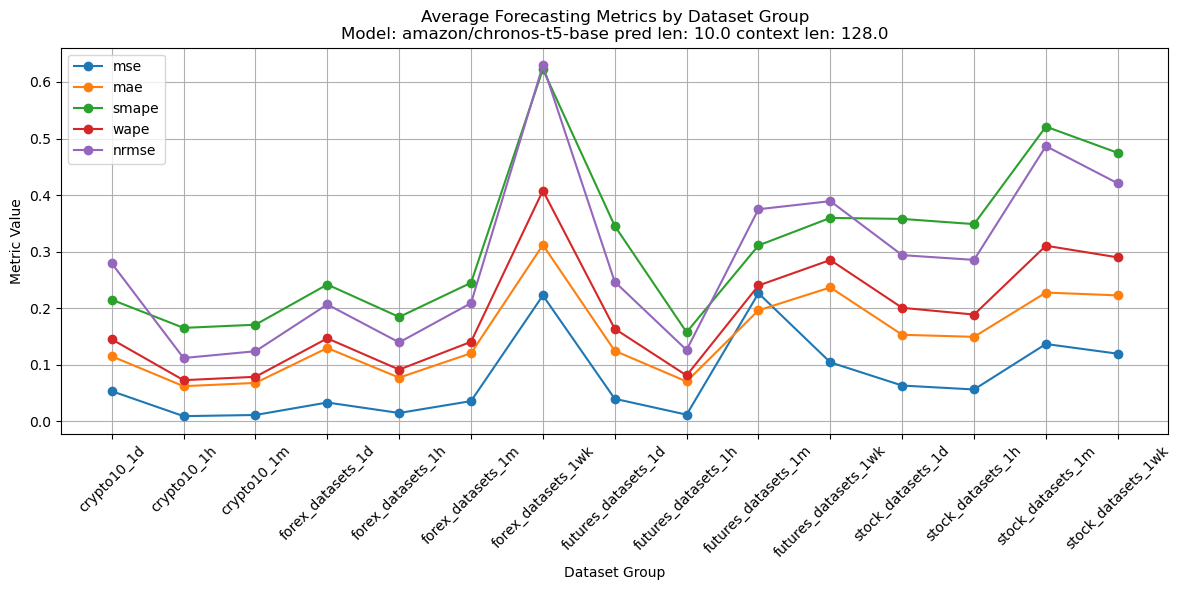


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=NRMSE
✅ Filled 'Chronos Medium' (pred_len=10) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: nrmse

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.087312  0.280281  0.152936  0.191467  0.361989   3173.333333   
1   0.018418  0.218928  0.089994  0.105382  0.156320  20320.000000   
2   0.024810  0.243412  0.100144  0.116643  0.183470   8293.333333   
3   0.060883  0.308675  0.172666  0.195584  0.277265   6400.000000   
4   0.029456  0.245448  0.110582  0.131102  0.194371  20213.333333   
5   0.066490  0.318125  0.166886  0.194656  0.289240  11680.000000   
6   0.374573  0.759461  0.430768  0.561295  0.811805   1520.000000   
7   0.068766  0.428529  0.166522  0.218527  0.325556   6760.000000   
8   0.020311  0.201536  0.098653  0.113432  0.163867  15600.000000   
9   0.244001  0.371405  0.231191  0.281210  0.426030   8626.666667   
10  0.156739  0.437424  0.290482  0.349941  0.476940   1520.000000   
11  0.110961  0.450892  0.208619  0.273143  0.391304   6315.879828   
12  0.104379  0.442198  0.206947  0.262442  0.390144   5163.666667   
13  0.269906  0.659430  0.321957  0.442508  0.688412   2474.188034   
14  0.202016  0.589165  0.296535  0.386554  0.548208   1821.176471   

         abs_sum  total_time  pred_len  context_len                 group  
0    2622.283936   10.954636      20.0        128.0           crypto10_1d  
1   17313.417969   69.238795      20.0        128.0           crypto10_1h  
2    7123.527507   28.246483      20.0        128.0           crypto10_1m  
3    5655.123047   22.082682      20.0        128.0     forex_datasets_1d  
4   17302.552083   68.413620      20.0        128.0     forex_datasets_1h  
5   10106.771484   39.869170      20.0        128.0     forex_datasets_1m  
6    1196.905538    5.300640      20.0        128.0    forex_datasets_1wk  
7    5121.516602   23.066282      20.0        128.0   futures_datasets_1d  
8   13567.410156   53.387169      20.0        128.0   futures_datasets_1h  
9    7438.841838   29.367866      20.0        128.0   futures_datasets_1m  
10   1261.736206    5.502228      20.0        128.0  futures_datasets_1wk  
11   5045.140767   21.194611      20.0        128.0     stock_datasets_1d  
12   4163.177339   17.270096      20.0        128.0     stock_datasets_1h  
13   1848.851493    8.300601      20.0        128.0     stock_datasets_1m  
14   1413.295853    6.122761      20.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.1226
smape              0.3970
mae                0.2030
wape               0.2549
nrmse              0.3790
num_elements    7992.1052
abs_sum         6745.3701
total_time        27.2212
pred_len          20.0000
context_len      128.0000
dtype: float64


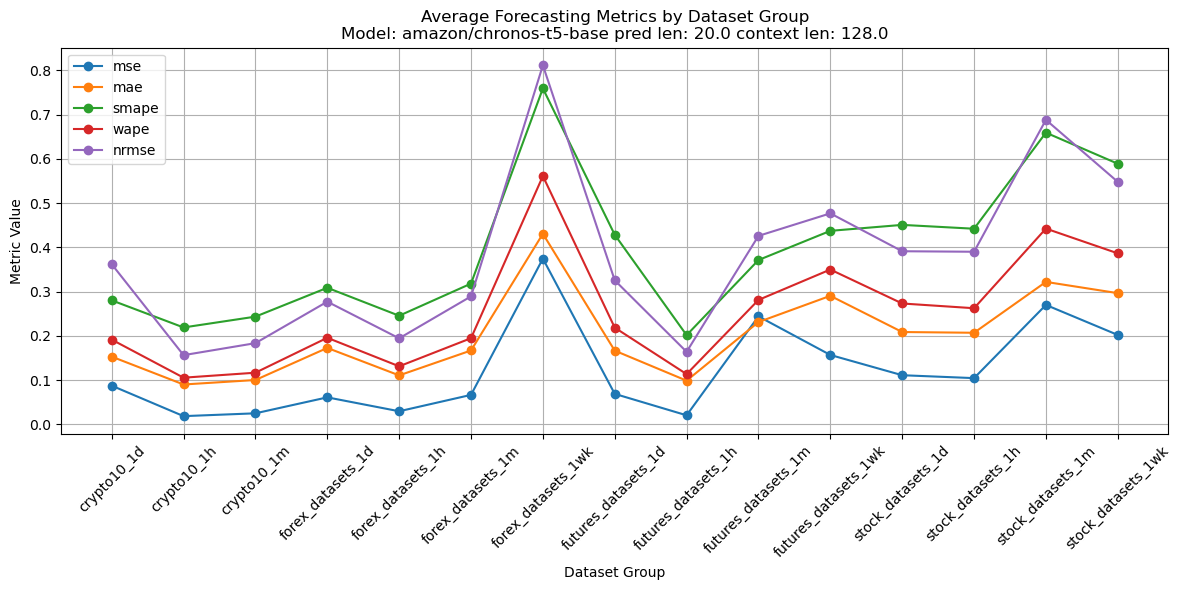


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=NRMSE
✅ Filled 'Chronos Medium' (pred_len=20) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: nrmse

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.138484  0.327624  0.193239  0.243750  0.460921   3120.000000   
1   0.024730  0.250653  0.105444  0.123557  0.180662  20280.000000   
2   0.043907  0.288132  0.133096  0.155084  0.242825   8280.000000   
3   0.089522  0.382582  0.222182  0.251604  0.335276   6360.000000   
4   0.041786  0.290885  0.135661  0.161289  0.234440  20160.000000   
5   0.092907  0.361713  0.200457  0.233680  0.345873  11640.000000   
6   0.388735  0.786881  0.435010  0.578279  0.835189   1440.000000   
7   0.103577  0.504710  0.205870  0.270992  0.396926   6720.000000   
8   0.031607  0.257145  0.125619  0.144438  0.204419  15600.000000   
9   0.260469  0.410703  0.254724  0.309146  0.462246   8580.000000   
10  0.211026  0.549855  0.335453  0.416046  0.569741   1440.000000   
11  0.164940  0.528453  0.256733  0.338191  0.480625   6282.746781   
12  0.149158  0.509141  0.250859  0.317585  0.464735   5163.500000   
13  0.308858  0.737657  0.364811  0.505015  0.740988   2445.641026   
14  0.278204  0.674081  0.354181  0.471722  0.656391   1766.823529   

         abs_sum  total_time  pred_len  context_len                 group  
0    2559.130046   10.494509      30.0        128.0           crypto10_1d  
1   17267.364258   67.066345      30.0        128.0           crypto10_1h  
2    7102.145345   27.458822      30.0        128.0           crypto10_1m  
3    5625.184814   21.325132      30.0        128.0     forex_datasets_1d  
4   17212.069661   66.109466      30.0        128.0     forex_datasets_1h  
5   10062.485677   38.503162      30.0        128.0     forex_datasets_1m  
6    1117.053060    4.923247      30.0        128.0    forex_datasets_1wk  
7    5068.270996   22.299176      30.0        128.0   futures_datasets_1d  
8   13567.412109   52.102547      30.0        128.0   futures_datasets_1h  
9    7389.731608   28.339815      30.0        128.0   futures_datasets_1m  
10   1161.055664    5.075302      30.0        128.0  futures_datasets_1wk  
11   5008.751638   20.498755      30.0        128.0     stock_datasets_1d  
12   4168.045179   16.864363      30.0        128.0     stock_datasets_1h  
13   1808.626365    7.998626      30.0        128.0     stock_datasets_1m  
14   1343.625452    5.776524      30.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.1552
smape              0.4573
mae                0.2382
wape               0.3014
nrmse              0.4408
num_elements    7951.9141
abs_sum         6697.3968
total_time        26.3224
pred_len          30.0000
context_len      128.0000
dtype: float64


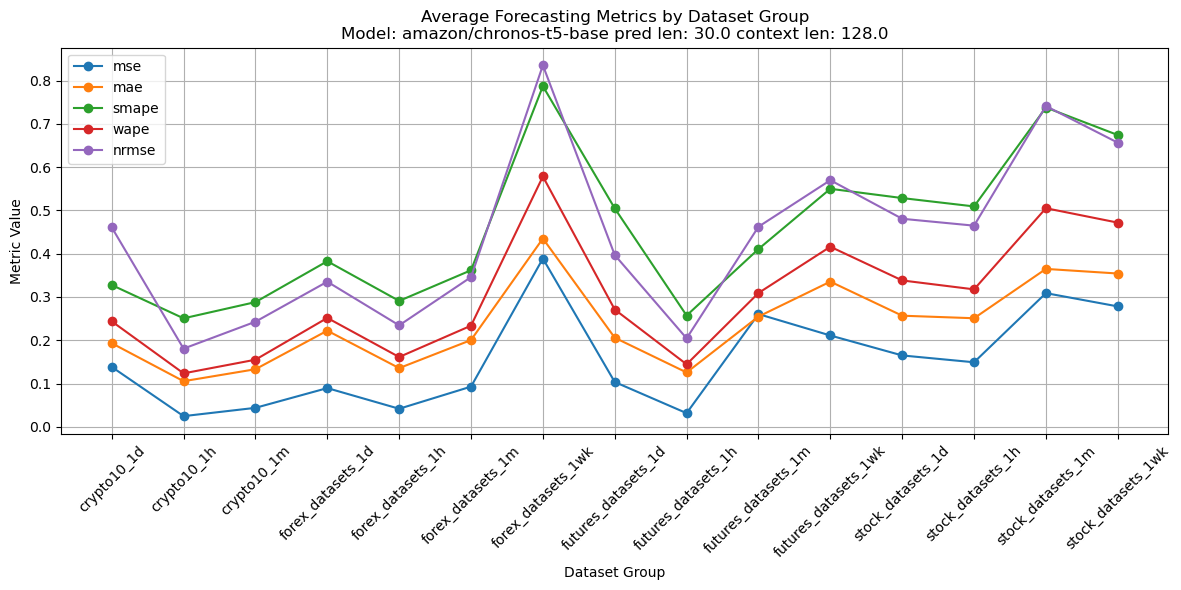


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=NRMSE
✅ Filled 'Chronos Medium' (pred_len=30) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: nrmse

📊 Summary of Mean Metrics per Dataset Group:


mse     smape       mae      wape     nrmse  num_elements  \
0   0.250216  0.453631  0.278767  0.351668  0.627806   3120.000000   
1   0.050495  0.332269  0.148321  0.174149  0.256700  20160.000000   
2   0.091866  0.396997  0.199059  0.232405  0.354221   8240.000000   
3   0.155244  0.483940  0.291053  0.331533  0.447304   6240.000000   
4   0.087859  0.393457  0.195392  0.232441  0.333968  20080.000000   
5   0.193314  0.484268  0.282717  0.330474  0.501328  11520.000000   
6   0.721485  0.979455  0.603891  0.788140  1.120183   1440.000000   
7   0.229425  0.610338  0.292865  0.388836  0.593901   6600.000000   
8   0.050622  0.288742  0.159396  0.183275  0.258700  15600.000000   
9   0.301169  0.484777  0.305360  0.367516  0.542156   8520.000000   
10  0.348858  0.643870  0.426013  0.528362  0.732544   1440.000000   
11  0.295300  0.672839  0.357116  0.472313  0.653507   6237.939914   
12  0.261253  0.647109  0.343926  0.436536  0.619640   5124.000000   
13  0.544892  0.938108  0.509478  0.709443  0.995843   2416.410256   
14  0.443772  0.850564  0.469621  0.631354  0.854157   1743.529412   

         abs_sum  total_time  pred_len  context_len                 group  
0    2559.130086   10.512485      60.0        128.0           crypto10_1d  
1   17140.966797   66.669837      60.0        128.0           crypto10_1h  
2    7039.945150   27.403459      60.0        128.0           crypto10_1m  
3    5487.800781   20.923788      60.0        128.0     forex_datasets_1d  
4   17142.236979   66.115750      60.0        128.0     forex_datasets_1h  
5    9928.854167   38.226665      60.0        128.0     forex_datasets_1m  
6    1117.053141    4.938406      60.0        128.0    forex_datasets_1wk  
7    4909.750000   22.100742      60.0        128.0   futures_datasets_1d  
8   13567.413086   52.223918      60.0        128.0   futures_datasets_1h  
9    7337.163656   28.141163      60.0        128.0   futures_datasets_1m  
10   1161.055664    5.082750      60.0        128.0  futures_datasets_1wk  
11   4942.476508   20.607203      60.0        128.0     stock_datasets_1d  
12   4125.142122   16.976611      60.0        128.0     stock_datasets_1h  
13   1778.563307    7.989278      60.0        128.0     stock_datasets_1m  
14   1306.227279    5.769339      60.0        128.0    stock_datasets_1wk


📌 Global Mean Across All Groups:
mse                0.2684
smape              0.5774
mae                0.3242
wape               0.4106
nrmse              0.5928
num_elements    7898.7920
abs_sum         6636.2519
total_time        26.2454
pred_len          60.0000
context_len      128.0000
dtype: float64


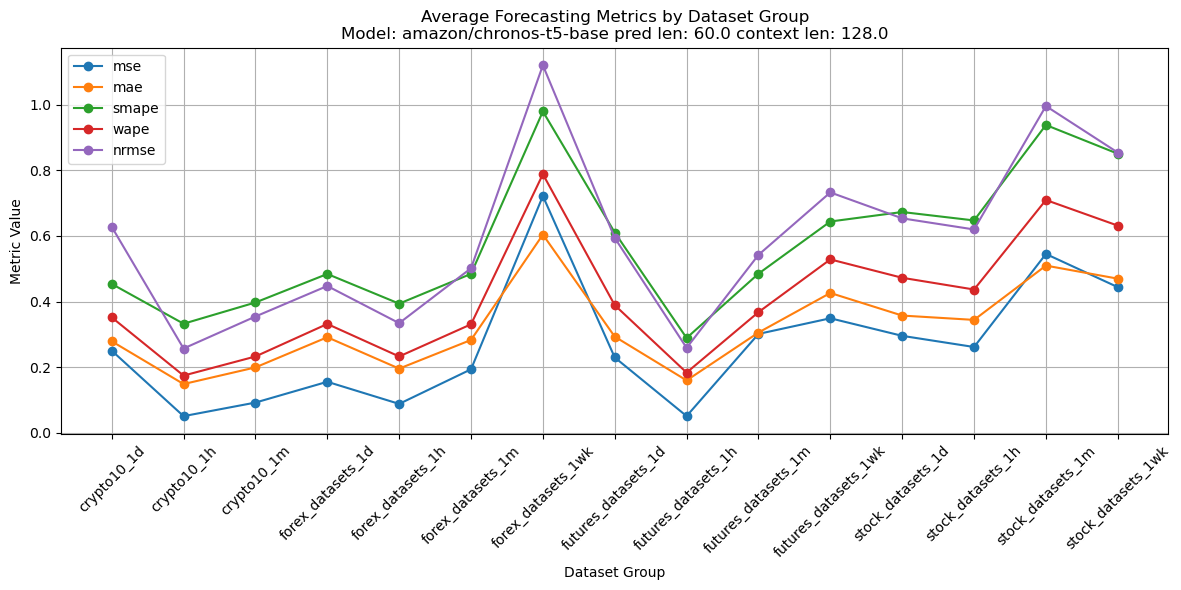


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'Chronos Medium'
  Col 6: model='Chronos Medium' | metric=NRMSE
✅ Filled 'Chronos Medium' (pred_len=60) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search_v2.xlsx, sheet: nrmse


In [5]:
metrics = ["MSE", "MAE", "SMAPE", "WAPE", "NRMSE"]
result_excel_path = r"results\chronos\chronos_medium_of1"
L = [10, 20, 30, 60]  
target_model = 'Chronos Medium'

for metric in metrics:
    for i in L:
        result_p = Path(r"{}\h{}".format(result_excel_path, str(i)))
        df = show_results(result_p)

        #data load into excel
        fill_model_metrics_into_excel(df, model_name=target_model, selected_metrics=[metric], excel_path=excel_file_path, output_path=excel_file_path, sheet_name=metric.lower())